# To do

* Clean up output
* Make functions for a lot of this

# Import packages and define functions

In [19]:
###################### Import Packages #############################################
import requests
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import copy
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
pd.options.display.max_rows = 999
pd.set_option('display.max_columns', 500)

####################################### Functions ######################################
shifted = pd.read_csv('final_frame_teams.csv')
shifted = shifted.replace('NULL', np.nan)

################ Seperate database by position ####################################################
pos_dict = {}
for pos in ['TE', 'WR', 'RB', 'QB']:
    pos_dict[pos] = shifted.loc[shifted.FantPos == pos].reset_index(drop = True)
    
    # center age to prepare for power relationship to reduce multicollinearity
    pos_dict[pos]['Age'] = pos_dict[pos]['Age'] - np.mean(pos_dict[pos]['Age']) 
    pos_dict[pos]['agesq'] = pos_dict[pos]['Age'] * pos_dict[pos]['Age']

# Random Forest Regressions

TE
Variable: Overall              Importance: 0.24
Variable: Dash                 Importance: 0.05
Variable: ReYds                Importance: 0.04
Variable: OvRank               Importance: 0.04
Variable: Pick                 Importance: 0.04
Variable: Rec_per_tgt          Importance: 0.03
Variable: Win_PCT              Importance: 0.03
Variable: Age                  Importance: 0.02
Variable: Tgt                  Importance: 0.02
Variable: Rec                  Importance: 0.02
Variable: ReYds/R              Importance: 0.02
Variable: FantPt               Importance: 0.02
Variable: PosRank              Importance: 0.02
Variable: ppg_this_year        Importance: 0.02
Variable: season_frac_3        Importance: 0.02
Variable: ReYds_per_R          Importance: 0.02
Variable: ReTD_per_rec         Importance: 0.02
Variable: start_frac           Importance: 0.02
Variable: Tgt_per_game         Importance: 0.02
Variable: Fant_Share           Importance: 0.02
Variable: Std.Dev              Import

Variable: Overall              Importance: 0.37
Variable: ReYds                Importance: 0.04
Variable: Rec_per_tgt          Importance: 0.04
Variable: Fmb                  Importance: 0.02
Variable: ppg_this_year        Importance: 0.02
Variable: RuTD_per_Att         Importance: 0.02
Variable: ReTD_per_rec         Importance: 0.02
Variable: Tgt_per_game         Importance: 0.02
Variable: RuAtt_per_game       Importance: 0.02
Variable: Fant_Share           Importance: 0.02
Variable: Pick                 Importance: 0.02
Variable: Wt                   Importance: 0.02
Variable: Dash                 Importance: 0.02
Variable: Age                  Importance: 0.01
Variable: GS                   Importance: 0.01
Variable: RuAtt                Importance: 0.01
Variable: RuYds                Importance: 0.01
Variable: RuY/A                Importance: 0.01
Variable: RuTD                 Importance: 0.01
Variable: Tgt                  Importance: 0.01
Variable: Rec                  Importanc

WR


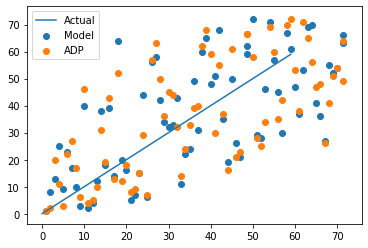

RB


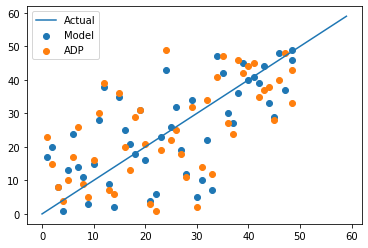

QB


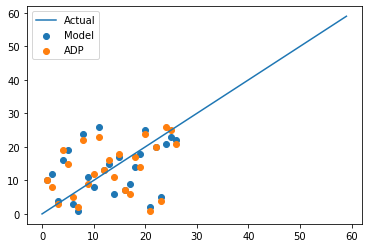

TE


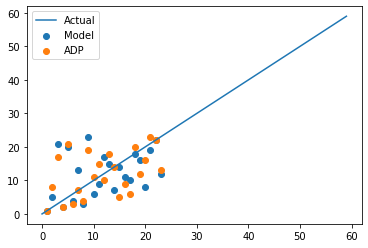

   Year Pos ADP_As_Predictor Points_Last_As_Predictor Model_As_Predictor
0  2014  WR          22000.5                    30129              21489
1  2014  RB           7745.5                    12812             6924.5
2  2014  QB             1878                   2457.5               2034
3  2014  TE             1106                   1237.5               1274
TE
Variable: Overall              Importance: 0.18
Variable: ReYds                Importance: 0.06
Variable: OvRank               Importance: 0.04
Variable: Pick                 Importance: 0.04
Variable: Dash                 Importance: 0.04
Variable: Rec_per_tgt          Importance: 0.03
Variable: ReTD_per_rec         Importance: 0.03
Variable: start_frac           Importance: 0.03
Variable: Tgt_per_game         Importance: 0.03
Variable: height               Importance: 0.03
Variable: Wt                   Importance: 0.03
Variable: Age                  Importance: 0.02
Variable: Tgt                  Importance: 0.02
Variable

Variable: Overall              Importance: 0.34
Variable: ReYds                Importance: 0.04
Variable: Rec_per_tgt          Importance: 0.04
Variable: ppg_this_year        Importance: 0.02
Variable: RuTD_per_Att         Importance: 0.02
Variable: ReTD_per_rec         Importance: 0.02
Variable: Tgt_per_game         Importance: 0.02
Variable: RuAtt_per_game       Importance: 0.02
Variable: Fant_Share           Importance: 0.02
Variable: Pick                 Importance: 0.02
Variable: Wt                   Importance: 0.02
Variable: Dash                 Importance: 0.02
Variable: Age                  Importance: 0.01
Variable: GS                   Importance: 0.01
Variable: RuAtt                Importance: 0.01
Variable: RuYds                Importance: 0.01
Variable: RuY/A                Importance: 0.01
Variable: RuTD                 Importance: 0.01
Variable: Tgt                  Importance: 0.01
Variable: Rec                  Importance: 0.01
Variable: ReYds/R              Importanc

WR


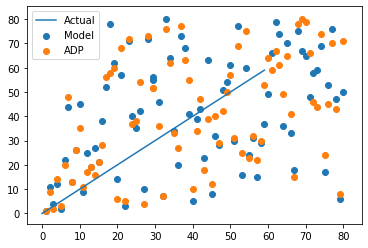

RB


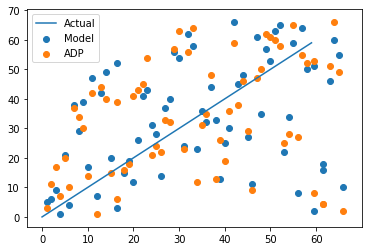

QB


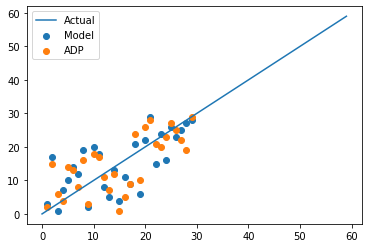

TE


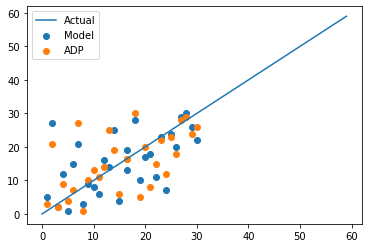

   Year Pos ADP_As_Predictor Points_Last_As_Predictor Model_As_Predictor
0  2015  WR            47728                  46761.5            53674.5
1  2015  RB            32241                  41639.5            30532.5
2  2015  QB             1256                     1986               1342
3  2015  TE             1920                   1687.5             2057.5
TE
Variable: Overall              Importance: 0.18
Variable: ReYds                Importance: 0.05
Variable: OvRank               Importance: 0.04
Variable: Tgt_per_game         Importance: 0.04
Variable: Pick                 Importance: 0.04
Variable: Rec_per_tgt          Importance: 0.03
Variable: ReTD_per_rec         Importance: 0.03
Variable: start_frac           Importance: 0.03
Variable: Fant_Share           Importance: 0.03
Variable: Wt                   Importance: 0.03
Variable: Dash                 Importance: 0.03
Variable: Age                  Importance: 0.02
Variable: GS                   Importance: 0.02
Variable

Variable: Overall              Importance: 0.33
Variable: ReYds                Importance: 0.03
Variable: Fmb                  Importance: 0.03
Variable: Rec_per_tgt          Importance: 0.03
Variable: ReTD_per_rec         Importance: 0.03
Variable: RuY/A                Importance: 0.02
Variable: ppg_this_year        Importance: 0.02
Variable: RuYds_per_A          Importance: 0.02
Variable: RuTD_per_Att         Importance: 0.02
Variable: Tgt_per_game         Importance: 0.02
Variable: RuAtt_per_game       Importance: 0.02
Variable: Fant_Share           Importance: 0.02
Variable: Pick                 Importance: 0.02
Variable: Wt                   Importance: 0.02
Variable: Vertical             Importance: 0.02
Variable: Bench                Importance: 0.02
Variable: Age                  Importance: 0.01
Variable: GS                   Importance: 0.01
Variable: RuAtt                Importance: 0.01
Variable: RuYds                Importance: 0.01
Variable: RuTD                 Importanc

WR


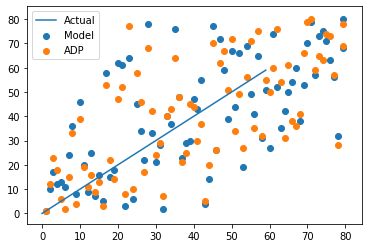

RB


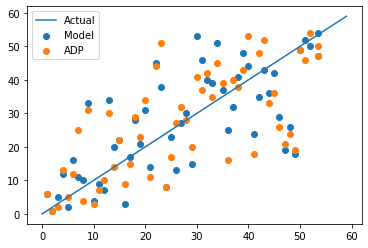

QB


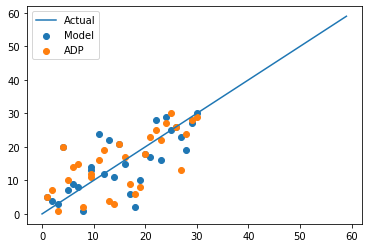

TE


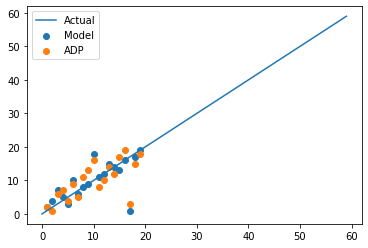

   Year Pos ADP_As_Predictor Points_Last_As_Predictor Model_As_Predictor
0  2016  WR          28950.5                  38230.5            32155.5
1  2016  RB           8032.5                     9468             7592.5
2  2016  QB           1406.5                   1635.5             1356.5
3  2016  TE              332                      584                372
TE
Variable: Overall              Importance: 0.21
Variable: Pick                 Importance: 0.05
Variable: ReYds                Importance: 0.04
Variable: ReTD_per_rec         Importance: 0.04
Variable: Tgt_per_game         Importance: 0.04
Variable: OvRank               Importance: 0.03
Variable: Rec_per_tgt          Importance: 0.03
Variable: Std.Dev              Importance: 0.03
Variable: Wt                   Importance: 0.03
Variable: Dash                 Importance: 0.03
Variable: Age                  Importance: 0.02
Variable: Tgt                  Importance: 0.02
Variable: Rec                  Importance: 0.02
Variable

Variable: Overall              Importance: 0.35
Variable: ReYds                Importance: 0.03
Variable: Fmb                  Importance: 0.03
Variable: Rec_per_tgt          Importance: 0.03
Variable: RuAtt_per_game       Importance: 0.03
Variable: ppg_this_year        Importance: 0.02
Variable: RuTD_per_Att         Importance: 0.02
Variable: ReTD_per_rec         Importance: 0.02
Variable: Tgt_per_game         Importance: 0.02
Variable: Fant_Share           Importance: 0.02
Variable: Std.Dev              Importance: 0.02
Variable: Pick                 Importance: 0.02
Variable: Wt                   Importance: 0.02
Variable: Vertical             Importance: 0.02
Variable: Bench                Importance: 0.02
Variable: Age                  Importance: 0.01
Variable: GS                   Importance: 0.01
Variable: RuAtt                Importance: 0.01
Variable: RuYds                Importance: 0.01
Variable: RuY/A                Importance: 0.01
Variable: RuTD                 Importanc

WR


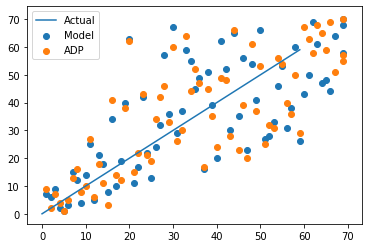

RB


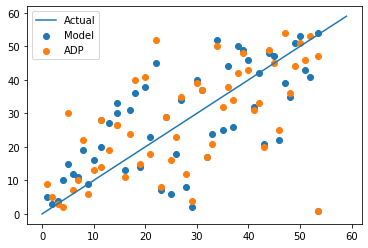

QB


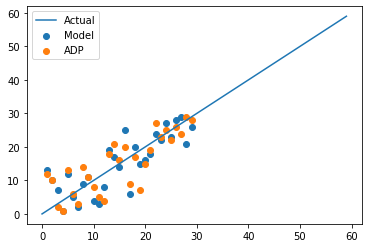

TE


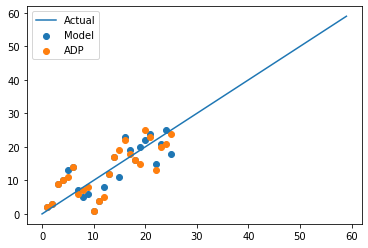

   Year Pos ADP_As_Predictor Points_Last_As_Predictor Model_As_Predictor
0  2017  WR            14050                    22832              16262
1  2017  RB             9827                    18280            10460.5
2  2017  QB              794                   2413.5                806
3  2017  TE              568                      822                566
TE
Variable: Overall              Importance: 0.23
Variable: ReYds                Importance: 0.05
Variable: Std.Dev              Importance: 0.05
Variable: Rec_per_tgt          Importance: 0.04
Variable: ReTD_per_rec         Importance: 0.04
Variable: Tgt_per_game         Importance: 0.04
Variable: Pick                 Importance: 0.04
Variable: Tgt                  Importance: 0.03
Variable: Rec                  Importance: 0.03
Variable: Wt                   Importance: 0.03
Variable: Age                  Importance: 0.02
Variable: PosRank              Importance: 0.02
Variable: OvRank               Importance: 0.02
Variable

Variable: Overall              Importance: 0.37
Variable: ReYds                Importance: 0.03
Variable: Fmb                  Importance: 0.03
Variable: RuAtt_per_game       Importance: 0.03
Variable: Std.Dev              Importance: 0.03
Variable: ppg_this_year        Importance: 0.02
Variable: season_frac_2        Importance: 0.02
Variable: RuTD_per_Att         Importance: 0.02
Variable: Rec_per_tgt          Importance: 0.02
Variable: Tgt_per_game         Importance: 0.02
Variable: Fant_Share           Importance: 0.02
Variable: Pick                 Importance: 0.02
Variable: Vertical             Importance: 0.02
Variable: Bench                Importance: 0.02
Variable: Win_PCT              Importance: 0.02
Variable: Age                  Importance: 0.01
Variable: GS                   Importance: 0.01
Variable: RuAtt                Importance: 0.01
Variable: RuYds                Importance: 0.01
Variable: RuY/A                Importance: 0.01
Variable: Tgt                  Importanc

WR


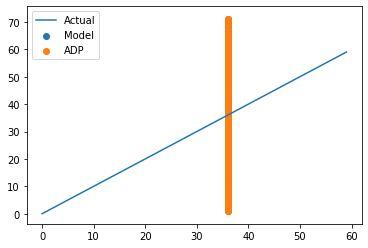

RB


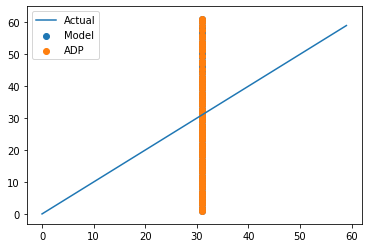

QB


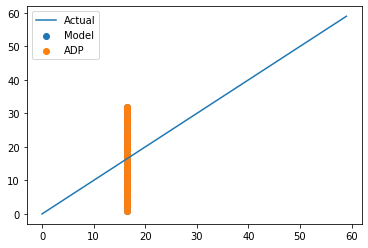

TE


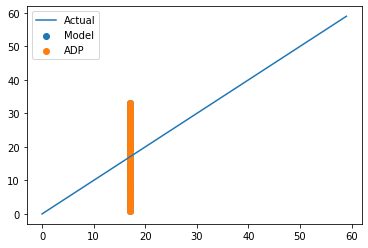

   Year Pos ADP_As_Predictor Points_Last_As_Predictor Model_As_Predictor
0  2018  WR          29819.5                    29820              29820
1  2018  RB          18908.5                    18909              18910
2  2018  QB             2728                     2728               2728
3  2018  TE             2992                   2991.5               2992
TE
Variable: Overall              Importance: 0.21
Variable: OvRank               Importance: 0.04
Variable: Pick                 Importance: 0.04
Variable: Dash                 Importance: 0.04
Variable: ReYds                Importance: 0.03
Variable: Rec_per_tgt          Importance: 0.03
Variable: Tgt_per_game         Importance: 0.03
Variable: height               Importance: 0.03
Variable: Wt                   Importance: 0.03
Variable: agesq                Importance: 0.03
Variable: Age                  Importance: 0.02
Variable: Tgt                  Importance: 0.02
Variable: Rec                  Importance: 0.02
Variable

Variable: Overall              Importance: 0.33
Variable: ReYds                Importance: 0.04
Variable: Rec_per_tgt          Importance: 0.04
Variable: Pick                 Importance: 0.03
Variable: Fmb                  Importance: 0.02
Variable: ppg_this_year        Importance: 0.02
Variable: RuTD_per_Att         Importance: 0.02
Variable: Tgt_per_game         Importance: 0.02
Variable: RuAtt_per_game       Importance: 0.02
Variable: Fant_Share           Importance: 0.02
Variable: Wt                   Importance: 0.02
Variable: Dash                 Importance: 0.02
Variable: Age                  Importance: 0.01
Variable: GS                   Importance: 0.01
Variable: RuAtt                Importance: 0.01
Variable: RuYds                Importance: 0.01
Variable: RuY/A                Importance: 0.01
Variable: RuTD                 Importance: 0.01
Variable: Tgt                  Importance: 0.01
Variable: Rec                  Importance: 0.01
Variable: ReYds/R              Importanc

WR


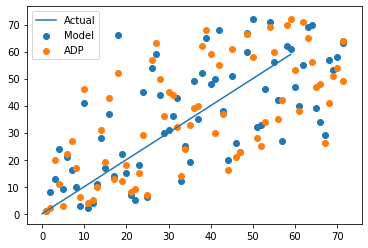

RB


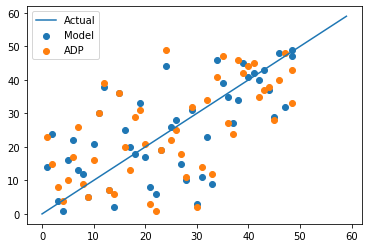

QB


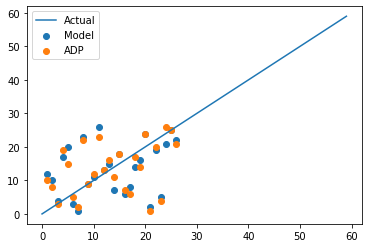

TE


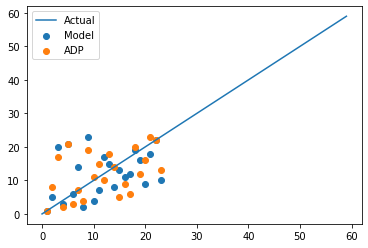

   Year Pos ADP_As_Predictor Points_Last_As_Predictor Model_As_Predictor
0  2014  WR          22000.5                    30129              20437
1  2014  RB           7745.5                    12812             7141.5
2  2014  QB             1878                   2457.5               2080
3  2014  TE             1106                   1237.5               1316
TE
Variable: Overall              Importance: 0.15
Variable: OvRank               Importance: 0.06
Variable: ReYds                Importance: 0.04
Variable: Tgt_per_game         Importance: 0.04
Variable: Dash                 Importance: 0.04
Variable: Tgt                  Importance: 0.03
Variable: FantPt               Importance: 0.03
Variable: ReTD_per_rec         Importance: 0.03
Variable: start_frac           Importance: 0.03
Variable: Std.Dev              Importance: 0.03
Variable: Pick                 Importance: 0.03
Variable: Wt                   Importance: 0.03
Variable: Age                  Importance: 0.02
Variable

Variable: Overall              Importance: 0.34
Variable: ReYds                Importance: 0.04
Variable: Rec_per_tgt          Importance: 0.04
Variable: Tgt                  Importance: 0.02
Variable: Fmb                  Importance: 0.02
Variable: ppg_this_year        Importance: 0.02
Variable: RuTD_per_Att         Importance: 0.02
Variable: ReTD_per_rec         Importance: 0.02
Variable: Tgt_per_game         Importance: 0.02
Variable: RuAtt_per_game       Importance: 0.02
Variable: Fant_Share           Importance: 0.02
Variable: Pick                 Importance: 0.02
Variable: Wt                   Importance: 0.02
Variable: Dash                 Importance: 0.02
Variable: Vertical             Importance: 0.02
Variable: Age                  Importance: 0.01
Variable: GS                   Importance: 0.01
Variable: RuAtt                Importance: 0.01
Variable: RuYds                Importance: 0.01
Variable: RuY/A                Importance: 0.01
Variable: RuTD                 Importanc

WR


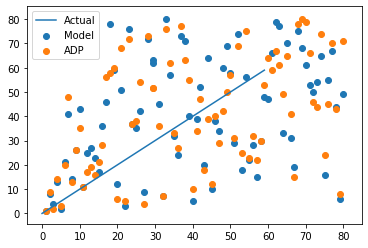

RB


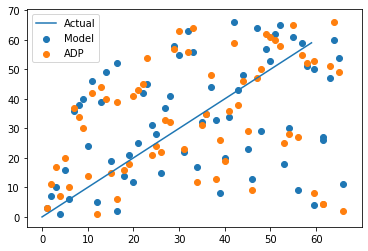

QB


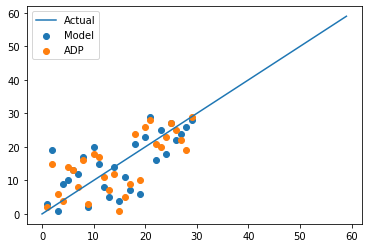

TE


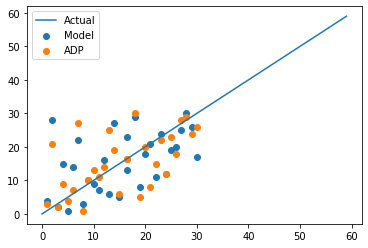

   Year Pos ADP_As_Predictor Points_Last_As_Predictor Model_As_Predictor
0  2015  WR            47728                  46761.5            54114.5
1  2015  RB            32241                  41639.5            30335.5
2  2015  QB             1256                     1986               1354
3  2015  TE             1920                   1687.5             2313.5
TE
Variable: Overall              Importance: 0.18
Variable: ReYds                Importance: 0.05
Variable: Pick                 Importance: 0.05
Variable: Tgt_per_game         Importance: 0.04
Variable: OvRank               Importance: 0.03
Variable: Rec_per_tgt          Importance: 0.03
Variable: ReTD_per_rec         Importance: 0.03
Variable: Fant_Share           Importance: 0.03
Variable: Std.Dev              Importance: 0.03
Variable: Wt                   Importance: 0.03
Variable: Dash                 Importance: 0.03
Variable: Age                  Importance: 0.02
Variable: Tgt                  Importance: 0.02
Variable

Variable: Overall              Importance: 0.33
Variable: ReYds                Importance: 0.03
Variable: Fmb                  Importance: 0.03
Variable: Rec_per_tgt          Importance: 0.03
Variable: ppg_this_year        Importance: 0.02
Variable: ReTD_per_rec         Importance: 0.02
Variable: Tgt_per_game         Importance: 0.02
Variable: RuAtt_per_game       Importance: 0.02
Variable: Fant_Share           Importance: 0.02
Variable: Std.Dev              Importance: 0.02
Variable: Pick                 Importance: 0.02
Variable: Wt                   Importance: 0.02
Variable: Dash                 Importance: 0.02
Variable: Vertical             Importance: 0.02
Variable: Bench                Importance: 0.02
Variable: Age                  Importance: 0.01
Variable: GS                   Importance: 0.01
Variable: RuAtt                Importance: 0.01
Variable: RuYds                Importance: 0.01
Variable: RuY/A                Importance: 0.01
Variable: RuTD                 Importanc

WR


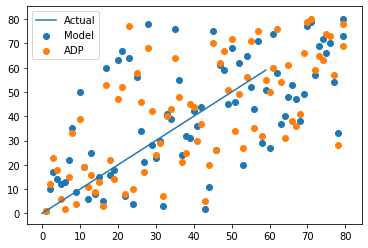

RB


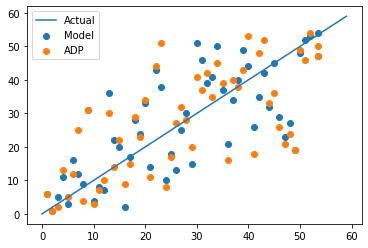

QB


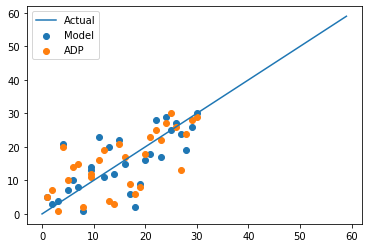

TE


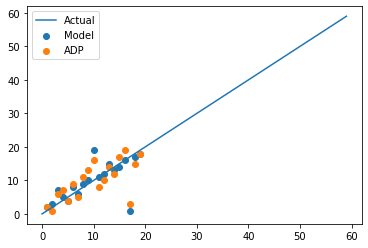

   Year Pos ADP_As_Predictor Points_Last_As_Predictor Model_As_Predictor
0  2016  WR          28950.5                  38230.5            33520.5
1  2016  RB           8032.5                     9468             7270.5
2  2016  QB           1406.5                   1635.5             1356.5
3  2016  TE              332                      584                372
TE
Variable: Overall              Importance: 0.19
Variable: ReYds                Importance: 0.06
Variable: ReTD_per_rec         Importance: 0.04
Variable: Std.Dev              Importance: 0.04
Variable: Pick                 Importance: 0.04
Variable: Wt                   Importance: 0.04
Variable: Rec_per_tgt          Importance: 0.03
Variable: start_frac           Importance: 0.03
Variable: Tgt_per_game         Importance: 0.03
Variable: Dash                 Importance: 0.03
Variable: Age                  Importance: 0.02
Variable: Tgt                  Importance: 0.02
Variable: Rec                  Importance: 0.02
Variable

Variable: Overall              Importance: 0.36
Variable: Fmb                  Importance: 0.03
Variable: Rec_per_tgt          Importance: 0.03
Variable: RuAtt_per_game       Importance: 0.03
Variable: Std.Dev              Importance: 0.03
Variable: ReYds                Importance: 0.02
Variable: ppg_this_year        Importance: 0.02
Variable: season_frac_2        Importance: 0.02
Variable: RuTD_per_Att         Importance: 0.02
Variable: ReTD_per_rec         Importance: 0.02
Variable: Tgt_per_game         Importance: 0.02
Variable: Fant_Share           Importance: 0.02
Variable: Pick                 Importance: 0.02
Variable: Vertical             Importance: 0.02
Variable: Bench                Importance: 0.02
Variable: Age                  Importance: 0.01
Variable: GS                   Importance: 0.01
Variable: RuAtt                Importance: 0.01
Variable: RuYds                Importance: 0.01
Variable: RuY/A                Importance: 0.01
Variable: RuTD                 Importanc

WR


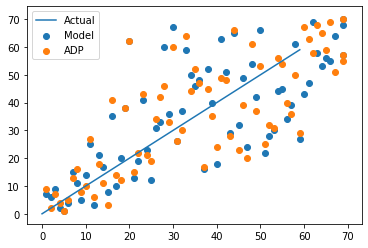

RB


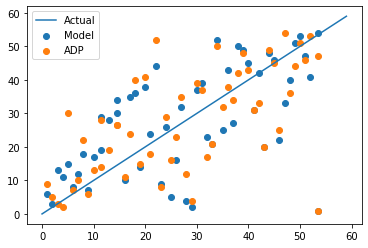

QB


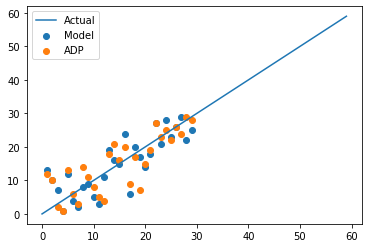

TE


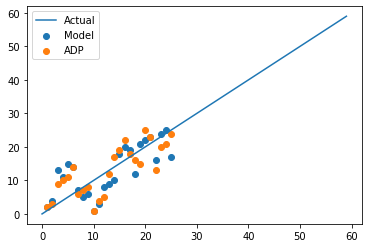

   Year Pos ADP_As_Predictor Points_Last_As_Predictor Model_As_Predictor
0  2017  WR            14050                    22832              15868
1  2017  RB             9827                    18280            10789.5
2  2017  QB              794                   2413.5                784
3  2017  TE              568                      822                708
TE
Variable: Overall              Importance: 0.28
Variable: ReYds                Importance: 0.05
Variable: Rec                  Importance: 0.04
Variable: Rec_per_tgt          Importance: 0.04
Variable: ReTD_per_rec         Importance: 0.04
Variable: Std.Dev              Importance: 0.04
Variable: Tgt                  Importance: 0.03
Variable: Tgt_per_game         Importance: 0.03
Variable: PosRank              Importance: 0.02
Variable: Fant_Share           Importance: 0.02
Variable: Pick                 Importance: 0.02
Variable: Wt                   Importance: 0.02
Variable: Dash                 Importance: 0.02
Variable

Variable: Overall              Importance: 0.37
Variable: ReYds                Importance: 0.03
Variable: ppg_this_year        Importance: 0.03
Variable: RuAtt_per_game       Importance: 0.03
Variable: Std.Dev              Importance: 0.03
Variable: season_frac_2        Importance: 0.02
Variable: Rec_per_tgt          Importance: 0.02
Variable: ReTD_per_rec         Importance: 0.02
Variable: Tgt_per_game         Importance: 0.02
Variable: Fant_Share           Importance: 0.02
Variable: Pick                 Importance: 0.02
Variable: Three_Cone           Importance: 0.02
Variable: Age                  Importance: 0.01
Variable: GS                   Importance: 0.01
Variable: RuAtt                Importance: 0.01
Variable: RuYds                Importance: 0.01
Variable: RuY/A                Importance: 0.01
Variable: Tgt                  Importance: 0.01
Variable: Rec                  Importance: 0.01
Variable: ReYds/R              Importance: 0.01
Variable: Fmb                  Importanc

WR


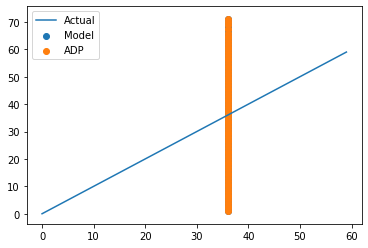

RB


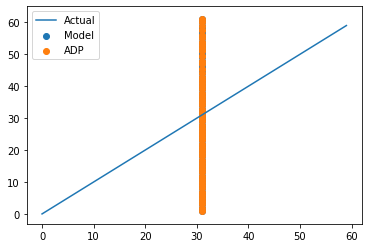

QB


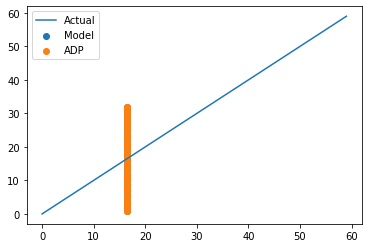

TE


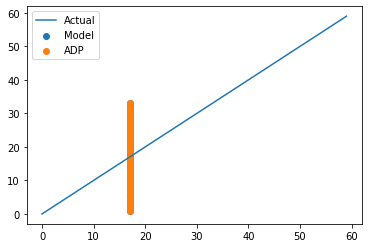

   Year Pos ADP_As_Predictor Points_Last_As_Predictor Model_As_Predictor
0  2018  WR          29819.5                    29820              29820
1  2018  RB          18908.5                    18909              18910
2  2018  QB             2728                     2728               2728
3  2018  TE             2992                   2991.5               2992
TE
Variable: Overall              Importance: 0.17
Variable: OvRank               Importance: 0.05
Variable: Dash                 Importance: 0.05
Variable: PosRank              Importance: 0.03
Variable: Rec_per_tgt          Importance: 0.03
Variable: ReTD_per_rec         Importance: 0.03
Variable: start_frac           Importance: 0.03
Variable: Tgt_per_game         Importance: 0.03
Variable: Pick                 Importance: 0.03
Variable: Wt                   Importance: 0.03
Variable: agesq                Importance: 0.03
Variable: Age                  Importance: 0.02
Variable: GS                   Importance: 0.02
Variable

Variable: Overall              Importance: 0.34
Variable: ReYds                Importance: 0.04
Variable: Rec_per_tgt          Importance: 0.04
Variable: Fmb                  Importance: 0.03
Variable: Fant_Share           Importance: 0.03
Variable: ppg_this_year        Importance: 0.02
Variable: RuTD_per_Att         Importance: 0.02
Variable: ReTD_per_rec         Importance: 0.02
Variable: Tgt_per_game         Importance: 0.02
Variable: RuAtt_per_game       Importance: 0.02
Variable: Pick                 Importance: 0.02
Variable: Wt                   Importance: 0.02
Variable: Dash                 Importance: 0.02
Variable: Age                  Importance: 0.01
Variable: GS                   Importance: 0.01
Variable: RuAtt                Importance: 0.01
Variable: RuYds                Importance: 0.01
Variable: RuY/A                Importance: 0.01
Variable: RuTD                 Importance: 0.01
Variable: Tgt                  Importance: 0.01
Variable: Rec                  Importanc

WR


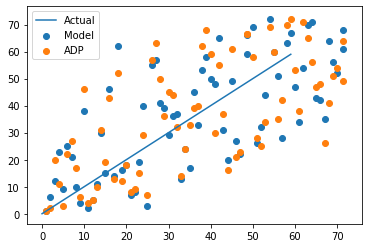

RB


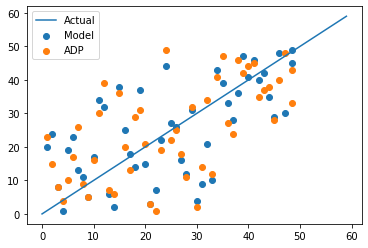

QB


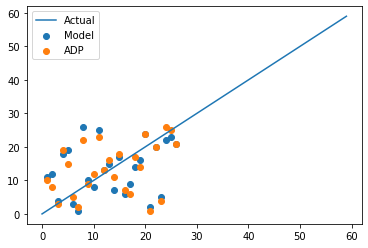

TE


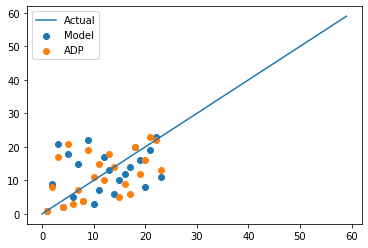

   Year Pos ADP_As_Predictor Points_Last_As_Predictor Model_As_Predictor
0  2014  WR          22000.5                    30129              19171
1  2014  RB           7745.5                    12812             7645.5
2  2014  QB             1878                   2457.5               2148
3  2014  TE             1106                   1237.5               1306
TE
Variable: Overall              Importance: 0.15
Variable: ReYds                Importance: 0.05
Variable: OvRank               Importance: 0.05
Variable: Tgt_per_game         Importance: 0.04
Variable: Pick                 Importance: 0.04
Variable: Tgt                  Importance: 0.03
Variable: Rec_per_tgt          Importance: 0.03
Variable: ReTD_per_rec         Importance: 0.03
Variable: start_frac           Importance: 0.03
Variable: Fant_Share           Importance: 0.03
Variable: Std.Dev              Importance: 0.03
Variable: height               Importance: 0.03
Variable: Wt                   Importance: 0.03
Variable

Variable: Overall              Importance: 0.35
Variable: ReYds                Importance: 0.04
Variable: Rec_per_tgt          Importance: 0.03
Variable: ReYds/R              Importance: 0.02
Variable: Fmb                  Importance: 0.02
Variable: ppg_this_year        Importance: 0.02
Variable: ReYds_per_R          Importance: 0.02
Variable: RuTD_per_Att         Importance: 0.02
Variable: ReTD_per_rec         Importance: 0.02
Variable: Tgt_per_game         Importance: 0.02
Variable: RuAtt_per_game       Importance: 0.02
Variable: Fant_Share           Importance: 0.02
Variable: Std.Dev              Importance: 0.02
Variable: Pick                 Importance: 0.02
Variable: Wt                   Importance: 0.02
Variable: Dash                 Importance: 0.02
Variable: Vertical             Importance: 0.02
Variable: Age                  Importance: 0.01
Variable: GS                   Importance: 0.01
Variable: RuAtt                Importance: 0.01
Variable: RuYds                Importanc

WR


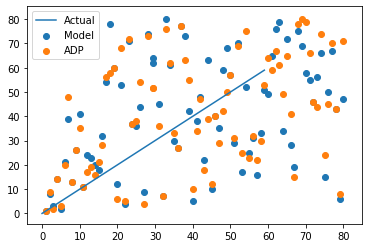

RB


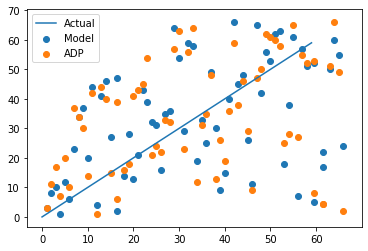

QB


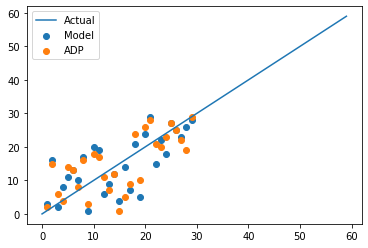

TE


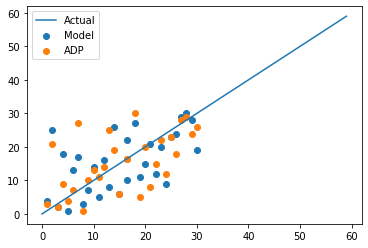

   Year Pos ADP_As_Predictor Points_Last_As_Predictor Model_As_Predictor
0  2015  WR            47728                  46761.5            54373.5
1  2015  RB            32241                  41639.5            28047.5
2  2015  QB             1256                     1986               1298
3  2015  TE             1920                   1687.5             1961.5
TE
Variable: Overall              Importance: 0.14
Variable: ReYds                Importance: 0.1
Variable: Std.Dev              Importance: 0.05
Variable: Pick                 Importance: 0.05
Variable: Rec_per_tgt          Importance: 0.03
Variable: ReTD_per_rec         Importance: 0.03
Variable: start_frac           Importance: 0.03
Variable: Tgt_per_game         Importance: 0.03
Variable: Fant_Share           Importance: 0.03
Variable: height               Importance: 0.03
Variable: Wt                   Importance: 0.03
Variable: Age                  Importance: 0.02
Variable: GS                   Importance: 0.02
Variable:

Variable: Overall              Importance: 0.34
Variable: RuAtt_per_game       Importance: 0.03
Variable: Std.Dev              Importance: 0.03
Variable: RuY/A                Importance: 0.02
Variable: ReYds                Importance: 0.02
Variable: Fmb                  Importance: 0.02
Variable: ppg_this_year        Importance: 0.02
Variable: season_frac_2        Importance: 0.02
Variable: RuYds_per_A          Importance: 0.02
Variable: RuTD_per_Att         Importance: 0.02
Variable: Rec_per_tgt          Importance: 0.02
Variable: ReTD_per_rec         Importance: 0.02
Variable: Tgt_per_game         Importance: 0.02
Variable: Fant_Share           Importance: 0.02
Variable: Pick                 Importance: 0.02
Variable: Vertical             Importance: 0.02
Variable: Bench                Importance: 0.02
Variable: Win_PCT              Importance: 0.02
Variable: Age                  Importance: 0.01
Variable: GS                   Importance: 0.01
Variable: RuAtt                Importanc

WR


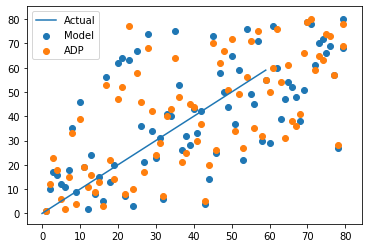

RB


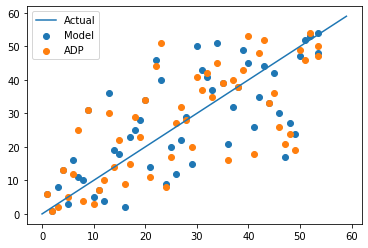

QB


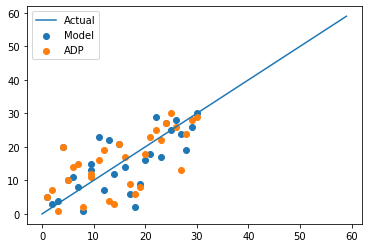

TE


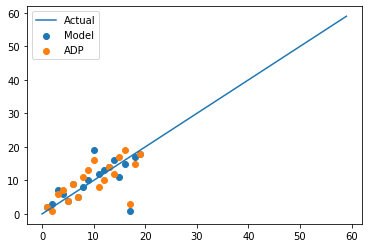

   Year Pos ADP_As_Predictor Points_Last_As_Predictor Model_As_Predictor
0  2016  WR          28950.5                  38230.5            31977.5
1  2016  RB           8032.5                     9468             7537.5
2  2016  QB           1406.5                   1635.5             1409.5
3  2016  TE              332                      584                400
TE
Variable: Overall              Importance: 0.24
Variable: ReYds                Importance: 0.06
Variable: Rec_per_tgt          Importance: 0.04
Variable: ReTD_per_rec         Importance: 0.04
Variable: Tgt_per_game         Importance: 0.04
Variable: Std.Dev              Importance: 0.04
Variable: Tgt                  Importance: 0.03
Variable: Rec                  Importance: 0.03
Variable: Pick                 Importance: 0.03
Variable: Wt                   Importance: 0.03
Variable: Dash                 Importance: 0.03
Variable: Age                  Importance: 0.02
Variable: PosRank              Importance: 0.02
Variable

Variable: Overall              Importance: 0.36
Variable: ppg_this_year        Importance: 0.03
Variable: Rec_per_tgt          Importance: 0.03
Variable: RuAtt_per_game       Importance: 0.03
Variable: ReYds                Importance: 0.02
Variable: G_prev_year          Importance: 0.02
Variable: season_frac_2        Importance: 0.02
Variable: ReTD_per_rec         Importance: 0.02
Variable: start_frac           Importance: 0.02
Variable: Tgt_per_game         Importance: 0.02
Variable: Fant_Share           Importance: 0.02
Variable: Std.Dev              Importance: 0.02
Variable: Pick                 Importance: 0.02
Variable: Vertical             Importance: 0.02
Variable: Bench                Importance: 0.02
Variable: Three_Cone           Importance: 0.02
Variable: Age                  Importance: 0.01
Variable: GS                   Importance: 0.01
Variable: RuAtt                Importance: 0.01
Variable: RuYds                Importance: 0.01
Variable: RuY/A                Importanc

WR


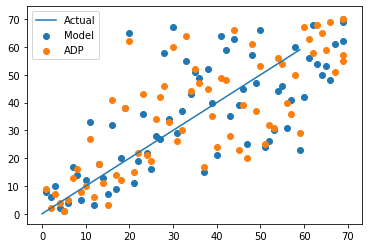

RB


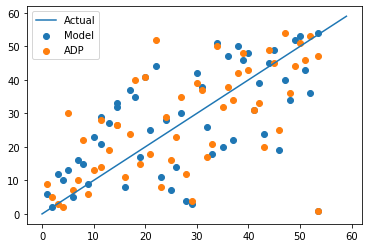

QB


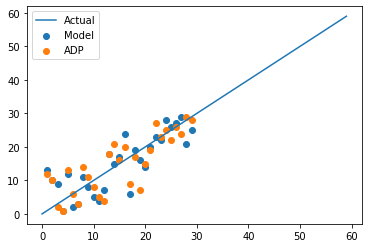

TE


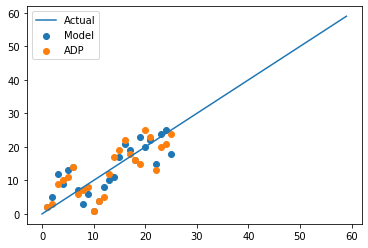

   Year Pos ADP_As_Predictor Points_Last_As_Predictor Model_As_Predictor
0  2017  WR            14050                    22832              15998
1  2017  RB             9827                    18280            11460.5
2  2017  QB              794                   2413.5                794
3  2017  TE              568                      822                596
TE
Variable: Overall              Importance: 0.25
Variable: ReYds                Importance: 0.11
Variable: Rec                  Importance: 0.04
Variable: Rec_per_tgt          Importance: 0.04
Variable: ReTD_per_rec         Importance: 0.04
Variable: Std.Dev              Importance: 0.04
Variable: PosRank              Importance: 0.03
Variable: Tgt_per_game         Importance: 0.03
Variable: Fant_Share           Importance: 0.03
Variable: Tgt                  Importance: 0.02
Variable: G_prev_year          Importance: 0.02
Variable: ppg_this_year        Importance: 0.02
Variable: Pick                 Importance: 0.02
Variable

Variable: Overall              Importance: 0.36
Variable: Std.Dev              Importance: 0.04
Variable: ppg_this_year        Importance: 0.03
Variable: RuAtt_per_game       Importance: 0.03
Variable: RuAtt                Importance: 0.02
Variable: ReYds                Importance: 0.02
Variable: season_frac_2        Importance: 0.02
Variable: Rec_per_tgt          Importance: 0.02
Variable: ReTD_per_rec         Importance: 0.02
Variable: Tgt_per_game         Importance: 0.02
Variable: Fant_Share           Importance: 0.02
Variable: Vertical             Importance: 0.02
Variable: Three_Cone           Importance: 0.02
Variable: Age                  Importance: 0.01
Variable: GS                   Importance: 0.01
Variable: RuYds                Importance: 0.01
Variable: RuY/A                Importance: 0.01
Variable: Tgt                  Importance: 0.01
Variable: Rec                  Importance: 0.01
Variable: ReYds/R              Importance: 0.01
Variable: Fmb                  Importanc

WR


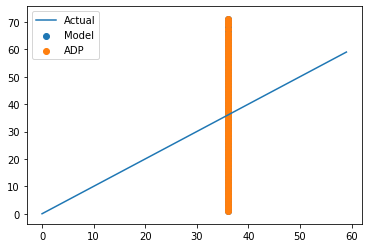

RB


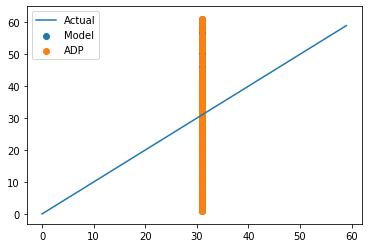

QB


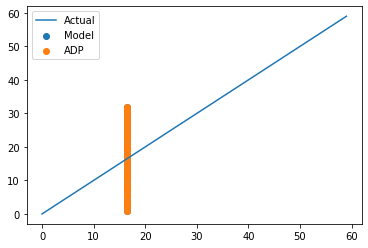

TE


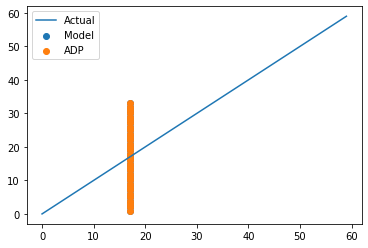

   Year Pos ADP_As_Predictor Points_Last_As_Predictor Model_As_Predictor
0  2018  WR          29819.5                    29820              29820
1  2018  RB          18908.5                    18909              18910
2  2018  QB             2728                     2728               2728
3  2018  TE             2992                   2991.5               2992
TE
Variable: Overall              Importance: 0.17
Variable: Dash                 Importance: 0.05
Variable: OvRank               Importance: 0.04
Variable: Tgt_per_game         Importance: 0.04
Variable: Pick                 Importance: 0.04
Variable: ReYds                Importance: 0.03
Variable: ReTD_per_rec         Importance: 0.03
Variable: Fant_Share           Importance: 0.03
Variable: height               Importance: 0.03
Variable: Wt                   Importance: 0.03
Variable: agesq                Importance: 0.03
Variable: Age                  Importance: 0.02
Variable: Tgt                  Importance: 0.02
Variable

Variable: Overall              Importance: 0.35
Variable: ReYds                Importance: 0.03
Variable: Rec_per_tgt          Importance: 0.03
Variable: Fant_Share           Importance: 0.03
Variable: Pick                 Importance: 0.03
Variable: ReYds/R              Importance: 0.02
Variable: Fmb                  Importance: 0.02
Variable: ppg_this_year        Importance: 0.02
Variable: ReYds_per_R          Importance: 0.02
Variable: ReTD_per_rec         Importance: 0.02
Variable: Tgt_per_game         Importance: 0.02
Variable: RuAtt_per_game       Importance: 0.02
Variable: Std.Dev              Importance: 0.02
Variable: Wt                   Importance: 0.02
Variable: Dash                 Importance: 0.02
Variable: Vertical             Importance: 0.02
Variable: Bench                Importance: 0.02
Variable: Age                  Importance: 0.01
Variable: GS                   Importance: 0.01
Variable: RuAtt                Importance: 0.01
Variable: RuYds                Importanc

WR


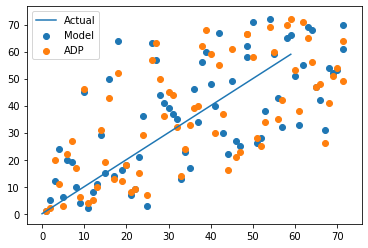

RB


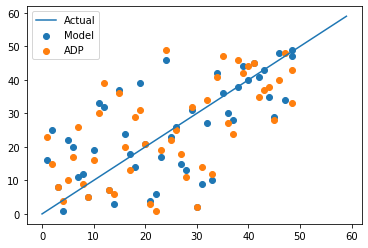

QB


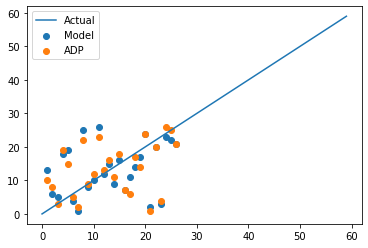

TE


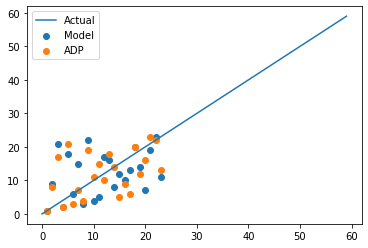

   Year Pos ADP_As_Predictor Points_Last_As_Predictor Model_As_Predictor
0  2014  WR          22000.5                    30129              20840
1  2014  RB           7745.5                    12812             7409.5
2  2014  QB             1878                   2457.5               2094
3  2014  TE             1106                   1237.5               1354
TE
Variable: Overall              Importance: 0.12
Variable: ReYds                Importance: 0.08
Variable: Std.Dev              Importance: 0.05
Variable: Tgt_per_game         Importance: 0.04
Variable: Pick                 Importance: 0.04
Variable: Tgt                  Importance: 0.03
Variable: OvRank               Importance: 0.03
Variable: ReTD_per_rec         Importance: 0.03
Variable: start_frac           Importance: 0.03
Variable: height               Importance: 0.03
Variable: Wt                   Importance: 0.03
Variable: Dash                 Importance: 0.03
Variable: agesq                Importance: 0.03
Variable

Variable: Overall              Importance: 0.36
Variable: ReYds                Importance: 0.03
Variable: Std.Dev              Importance: 0.03
Variable: ReYds/R              Importance: 0.02
Variable: ReYds_per_R          Importance: 0.02
Variable: RuTD_per_Att         Importance: 0.02
Variable: Rec_per_tgt          Importance: 0.02
Variable: ReTD_per_rec         Importance: 0.02
Variable: Tgt_per_game         Importance: 0.02
Variable: RuAtt_per_game       Importance: 0.02
Variable: Fant_Share           Importance: 0.02
Variable: Pick                 Importance: 0.02
Variable: Dash                 Importance: 0.02
Variable: Vertical             Importance: 0.02
Variable: Age                  Importance: 0.01
Variable: GS                   Importance: 0.01
Variable: RuAtt                Importance: 0.01
Variable: RuYds                Importance: 0.01
Variable: RuY/A                Importance: 0.01
Variable: RuTD                 Importance: 0.01
Variable: Tgt                  Importanc

WR


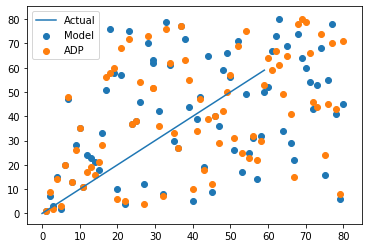

RB


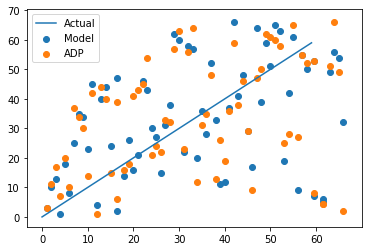

QB


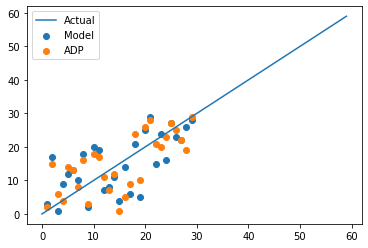

TE


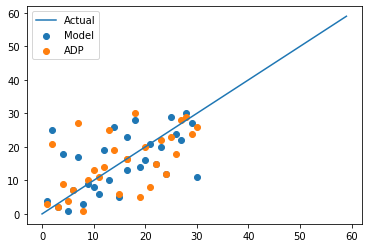

   Year Pos ADP_As_Predictor Points_Last_As_Predictor Model_As_Predictor
0  2015  WR            47728                  46761.5            54364.5
1  2015  RB            32241                  41639.5            29720.5
2  2015  QB             1256                     1986               1434
3  2015  TE             1920                   1687.5             2019.5
TE
Variable: Overall              Importance: 0.19
Variable: ReYds                Importance: 0.08
Variable: Tgt_per_game         Importance: 0.04
Variable: Std.Dev              Importance: 0.04
Variable: Rec                  Importance: 0.03
Variable: Rec_per_tgt          Importance: 0.03
Variable: ReTD_per_rec         Importance: 0.03
Variable: Pick                 Importance: 0.03
Variable: Wt                   Importance: 0.03
Variable: Dash                 Importance: 0.03
Variable: Age                  Importance: 0.02
Variable: GS                   Importance: 0.02
Variable: Tgt                  Importance: 0.02
Variable

Variable: Overall              Importance: 0.34
Variable: ppg_this_year        Importance: 0.03
Variable: Rec_per_tgt          Importance: 0.03
Variable: ReTD_per_rec         Importance: 0.03
Variable: RuAtt_per_game       Importance: 0.03
Variable: Std.Dev              Importance: 0.03
Variable: ReYds                Importance: 0.02
Variable: G_prev_year          Importance: 0.02
Variable: season_frac_2        Importance: 0.02
Variable: start_frac           Importance: 0.02
Variable: Tgt_per_game         Importance: 0.02
Variable: Fant_Share           Importance: 0.02
Variable: Pick                 Importance: 0.02
Variable: Vertical             Importance: 0.02
Variable: Three_Cone           Importance: 0.02
Variable: agesq                Importance: 0.02
Variable: Age                  Importance: 0.01
Variable: GS                   Importance: 0.01
Variable: RuAtt                Importance: 0.01
Variable: RuYds                Importance: 0.01
Variable: RuY/A                Importanc

WR


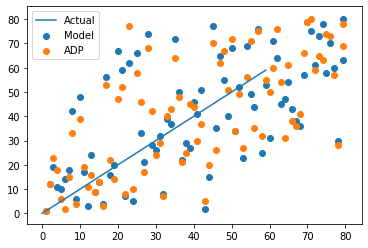

RB


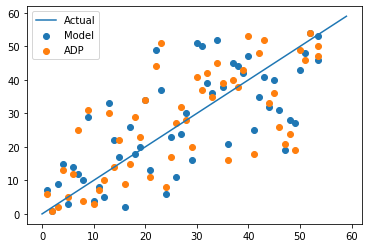

QB


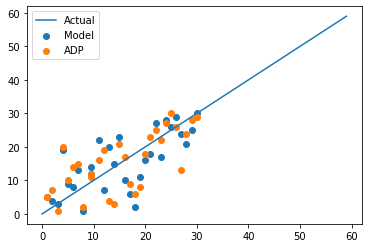

TE


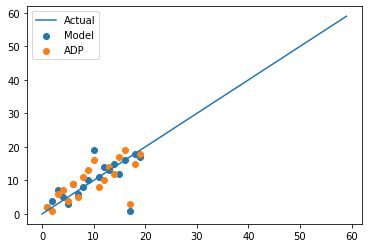

   Year Pos ADP_As_Predictor Points_Last_As_Predictor Model_As_Predictor
0  2016  WR          28950.5                  38230.5            32740.5
1  2016  RB           8032.5                     9468             7516.5
2  2016  QB           1406.5                   1635.5             1299.5
3  2016  TE              332                      584                392
TE
Variable: Overall              Importance: 0.16
Variable: ReYds                Importance: 0.15
Variable: Rec_per_tgt          Importance: 0.05
Variable: Rec                  Importance: 0.04
Variable: ReTD_per_rec         Importance: 0.04
Variable: PosRank              Importance: 0.03
Variable: Tgt_per_game         Importance: 0.03
Variable: Std.Dev              Importance: 0.03
Variable: Pick                 Importance: 0.03
Variable: Age                  Importance: 0.02
Variable: GS                   Importance: 0.02
Variable: Tgt                  Importance: 0.02
Variable: ppg_this_year        Importance: 0.02
Variable

Variable: Overall              Importance: 0.33
Variable: ppg_this_year        Importance: 0.04
Variable: RuAtt_per_game       Importance: 0.03
Variable: Std.Dev              Importance: 0.03
Variable: Vertical             Importance: 0.03
Variable: RuAtt                Importance: 0.02
Variable: Rec                  Importance: 0.02
Variable: season_frac_2        Importance: 0.02
Variable: Rec_per_tgt          Importance: 0.02
Variable: start_frac           Importance: 0.02
Variable: Tgt_per_game         Importance: 0.02
Variable: Fant_Share           Importance: 0.02
Variable: Three_Cone           Importance: 0.02
Variable: Age                  Importance: 0.01
Variable: GS                   Importance: 0.01
Variable: RuYds                Importance: 0.01
Variable: RuY/A                Importance: 0.01
Variable: Tgt                  Importance: 0.01
Variable: ReYds                Importance: 0.01
Variable: ReYds/R              Importance: 0.01
Variable: Fmb                  Importanc

WR


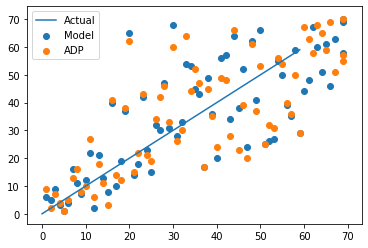

RB


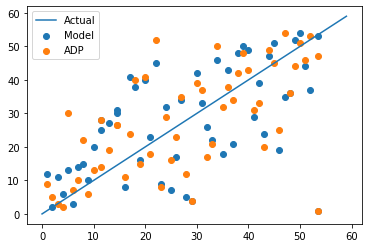

QB


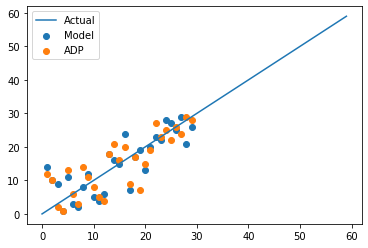

TE


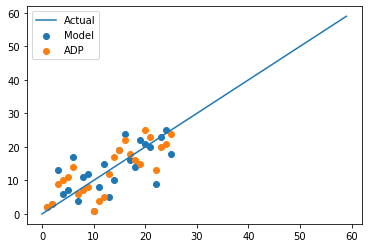

   Year Pos ADP_As_Predictor Points_Last_As_Predictor Model_As_Predictor
0  2017  WR            14050                    22832              14742
1  2017  RB             9827                    18280            11450.5
2  2017  QB              794                   2413.5                796
3  2017  TE              568                      822                764
TE
Variable: Overall              Importance: 0.22
Variable: ReYds                Importance: 0.08
Variable: Rec                  Importance: 0.06
Variable: Std.Dev              Importance: 0.06
Variable: PosRank              Importance: 0.05
Variable: ReTD_per_rec         Importance: 0.04
Variable: Rec_per_tgt          Importance: 0.03
Variable: Tgt_per_game         Importance: 0.03
Variable: Fant_Share           Importance: 0.03
Variable: Tgt                  Importance: 0.02
Variable: G_prev_year          Importance: 0.02
Variable: ppg_this_year        Importance: 0.02
Variable: start_frac           Importance: 0.02
Variable

Variable: Overall              Importance: 0.29
Variable: Std.Dev              Importance: 0.1
Variable: ppg_this_year        Importance: 0.04
Variable: Tgt_per_game         Importance: 0.04
Variable: RuAtt_per_game       Importance: 0.03
Variable: Age                  Importance: 0.02
Variable: RuAtt                Importance: 0.02
Variable: ReYds                Importance: 0.02
Variable: season_frac_2        Importance: 0.02
Variable: RuTD_per_Att         Importance: 0.02
Variable: Rec_per_tgt          Importance: 0.02
Variable: Fant_Share           Importance: 0.02
Variable: Pick                 Importance: 0.02
Variable: Vertical             Importance: 0.02
Variable: Bench                Importance: 0.02
Variable: Three_Cone           Importance: 0.02
Variable: Win_PCT              Importance: 0.02
Variable: GS                   Importance: 0.01
Variable: RuYds                Importance: 0.01
Variable: RuY/A                Importance: 0.01
Variable: Tgt                  Importance

WR


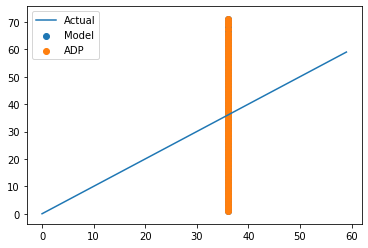

RB


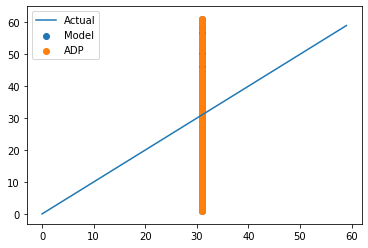

QB


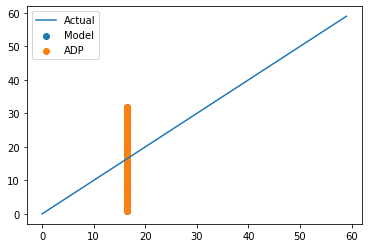

TE


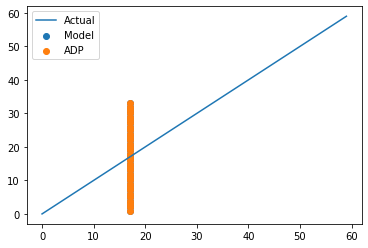

   Year Pos ADP_As_Predictor Points_Last_As_Predictor Model_As_Predictor
0  2018  WR          29819.5                    29820              29820
1  2018  RB          18908.5                    18909              18910
2  2018  QB             2728                     2728               2728
3  2018  TE             2992                   2991.5               2992
TE
Variable: Overall              Importance: 0.13
Variable: ReYds                Importance: 0.04
Variable: Std.Dev              Importance: 0.04
Variable: Pick                 Importance: 0.04
Variable: Dash                 Importance: 0.04
Variable: agesq                Importance: 0.04
Variable: Tgt                  Importance: 0.03
Variable: Rec                  Importance: 0.03
Variable: OvRank               Importance: 0.03
Variable: ReTD_per_rec         Importance: 0.03
Variable: start_frac           Importance: 0.03
Variable: Tgt_per_game         Importance: 0.03
Variable: Fant_Share           Importance: 0.03
Variable

Variable: Overall              Importance: 0.37
Variable: ReYds                Importance: 0.03
Variable: Rec_per_tgt          Importance: 0.03
Variable: Std.Dev              Importance: 0.03
Variable: Pick                 Importance: 0.03
Variable: ppg_this_year        Importance: 0.02
Variable: ReYds_per_R          Importance: 0.02
Variable: RuTD_per_Att         Importance: 0.02
Variable: Tgt_per_game         Importance: 0.02
Variable: RuAtt_per_game       Importance: 0.02
Variable: Fant_Share           Importance: 0.02
Variable: Dash                 Importance: 0.02
Variable: Vertical             Importance: 0.02
Variable: Bench                Importance: 0.02
Variable: Age                  Importance: 0.01
Variable: GS                   Importance: 0.01
Variable: RuAtt                Importance: 0.01
Variable: RuYds                Importance: 0.01
Variable: RuY/A                Importance: 0.01
Variable: RuTD                 Importance: 0.01
Variable: Tgt                  Importanc

WR


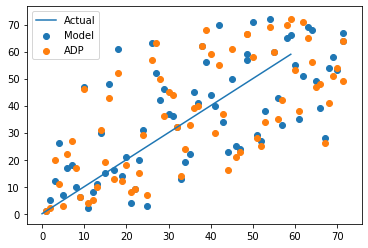

RB


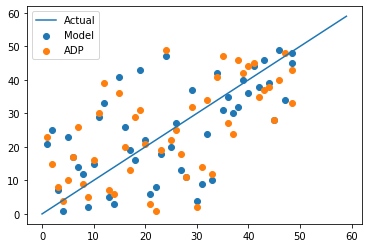

QB


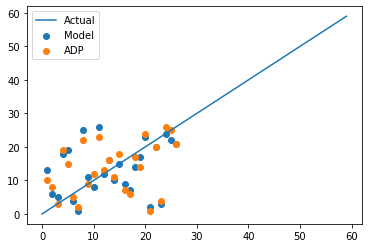

TE


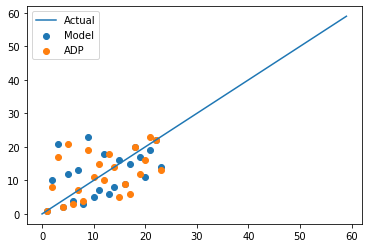

   Year Pos ADP_As_Predictor Points_Last_As_Predictor Model_As_Predictor
0  2014  WR          22000.5                    30129              20298
1  2014  RB           7745.5                    12812             7876.5
2  2014  QB             1878                   2457.5               2120
3  2014  TE             1106                   1237.5               1092
TE
Variable: Overall              Importance: 0.17
Variable: ReYds                Importance: 0.08
Variable: Tgt_per_game         Importance: 0.04
Variable: Std.Dev              Importance: 0.04
Variable: Tgt                  Importance: 0.03
Variable: OvRank               Importance: 0.03
Variable: Rec_per_tgt          Importance: 0.03
Variable: ReTD_per_rec         Importance: 0.03
Variable: start_frac           Importance: 0.03
Variable: height               Importance: 0.03
Variable: Wt                   Importance: 0.03
Variable: Dash                 Importance: 0.03
Variable: Age                  Importance: 0.02
Variable

Variable: Overall              Importance: 0.37
Variable: Std.Dev              Importance: 0.04
Variable: ReYds                Importance: 0.03
Variable: ppg_this_year        Importance: 0.03
Variable: Rec_per_tgt          Importance: 0.03
Variable: Tgt_per_game         Importance: 0.03
Variable: ReTD_per_rec         Importance: 0.02
Variable: start_frac           Importance: 0.02
Variable: RuAtt_per_game       Importance: 0.02
Variable: Fant_Share           Importance: 0.02
Variable: Pick                 Importance: 0.02
Variable: Vertical             Importance: 0.02
Variable: agesq                Importance: 0.02
Variable: Age                  Importance: 0.01
Variable: GS                   Importance: 0.01
Variable: RuAtt                Importance: 0.01
Variable: RuYds                Importance: 0.01
Variable: RuY/A                Importance: 0.01
Variable: Tgt                  Importance: 0.01
Variable: Rec                  Importance: 0.01
Variable: ReYds/R              Importanc

WR


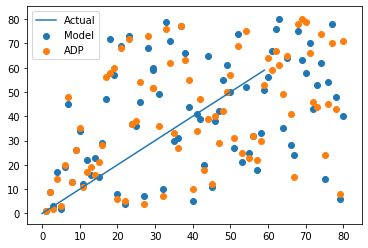

RB


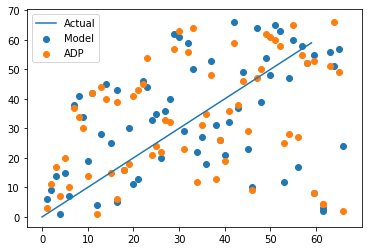

QB


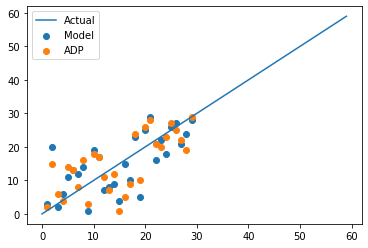

TE


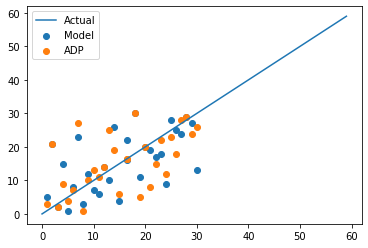

   Year Pos ADP_As_Predictor Points_Last_As_Predictor Model_As_Predictor
0  2015  WR            47728                  46761.5            52602.5
1  2015  RB            32241                  41639.5            30582.5
2  2015  QB             1256                     1986               1344
3  2015  TE             1920                   1687.5             1951.5
TE
Variable: ReYds                Importance: 0.2
Variable: Overall              Importance: 0.1
Variable: Rec                  Importance: 0.04
Variable: PosRank              Importance: 0.04
Variable: Rec_per_tgt          Importance: 0.04
Variable: Tgt_per_game         Importance: 0.04
Variable: Pick                 Importance: 0.04
Variable: ReTD_per_rec         Importance: 0.03
Variable: Std.Dev              Importance: 0.03
Variable: GS                   Importance: 0.02
Variable: Tgt                  Importance: 0.02
Variable: G_prev_year          Importance: 0.02
Variable: ppg_this_year        Importance: 0.02
Variable: 

Variable: Overall              Importance: 0.31
Variable: ppg_this_year        Importance: 0.04
Variable: Std.Dev              Importance: 0.04
Variable: RuAtt_per_game       Importance: 0.03
Variable: Vertical             Importance: 0.03
Variable: Rec                  Importance: 0.02
Variable: G_prev_year          Importance: 0.02
Variable: season_frac_2        Importance: 0.02
Variable: Rec_per_tgt          Importance: 0.02
Variable: ReTD_per_rec         Importance: 0.02
Variable: start_frac           Importance: 0.02
Variable: Tgt_per_game         Importance: 0.02
Variable: Fant_Share           Importance: 0.02
Variable: Three_Cone           Importance: 0.02
Variable: Win_PCT              Importance: 0.02
Variable: agesq                Importance: 0.02
Variable: Age                  Importance: 0.01
Variable: G                    Importance: 0.01
Variable: GS                   Importance: 0.01
Variable: RuAtt                Importance: 0.01
Variable: RuYds                Importanc

WR


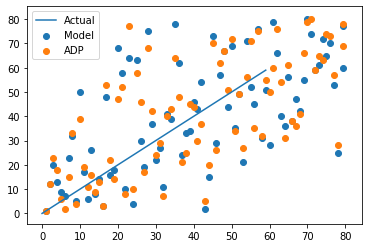

RB


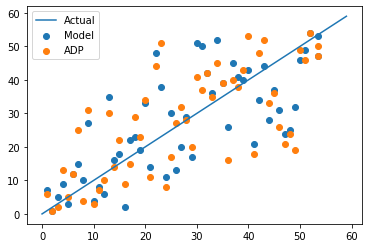

QB


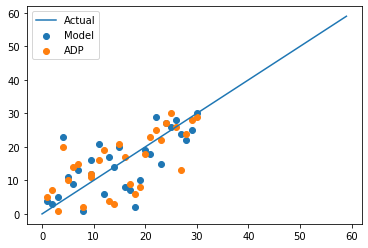

TE


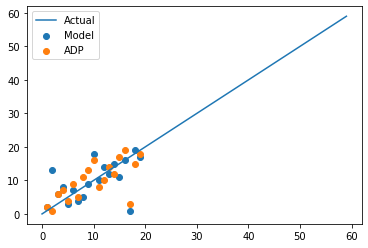

   Year Pos ADP_As_Predictor Points_Last_As_Predictor Model_As_Predictor
0  2016  WR          28950.5                  38230.5            34032.5
1  2016  RB           8032.5                     9468             6855.5
2  2016  QB           1406.5                   1635.5             1429.5
3  2016  TE              332                      584                518
TE
Variable: Overall              Importance: 0.14
Variable: ReYds                Importance: 0.1
Variable: Rec                  Importance: 0.07
Variable: PosRank              Importance: 0.06
Variable: Std.Dev              Importance: 0.05
Variable: Rec_per_tgt          Importance: 0.04
Variable: ReTD_per_rec         Importance: 0.04
Variable: Pick                 Importance: 0.04
Variable: FantPt               Importance: 0.03
Variable: Tgt_per_game         Importance: 0.03
Variable: GS                   Importance: 0.02
Variable: Tgt                  Importance: 0.02
Variable: ppg_this_year        Importance: 0.02
Variable:

Variable: Overall              Importance: 0.28
Variable: ppg_this_year        Importance: 0.06
Variable: Std.Dev              Importance: 0.05
Variable: Tgt_per_game         Importance: 0.04
Variable: Rec_per_tgt          Importance: 0.03
Variable: Vertical             Importance: 0.03
Variable: Rec                  Importance: 0.02
Variable: ReYds                Importance: 0.02
Variable: G_prev_year          Importance: 0.02
Variable: season_frac_2        Importance: 0.02
Variable: RuTD_per_Att         Importance: 0.02
Variable: RuAtt_per_game       Importance: 0.02
Variable: Fant_Share           Importance: 0.02
Variable: Pick                 Importance: 0.02
Variable: Three_Cone           Importance: 0.02
Variable: Win_PCT              Importance: 0.02
Variable: Age                  Importance: 0.01
Variable: GS                   Importance: 0.01
Variable: RuAtt                Importance: 0.01
Variable: RuYds                Importance: 0.01
Variable: RuY/A                Importanc

WR


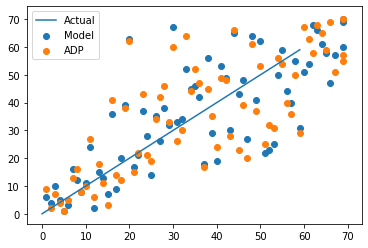

RB


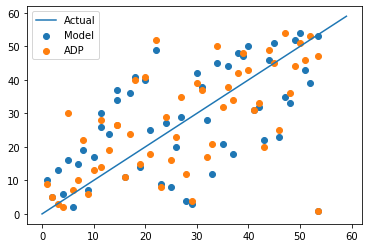

QB


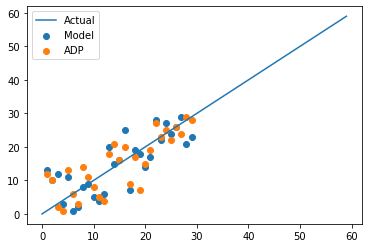

TE


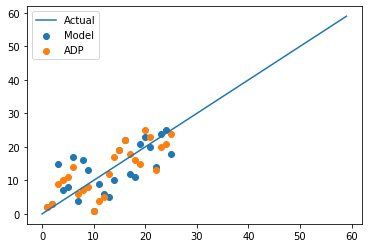

   Year Pos ADP_As_Predictor Points_Last_As_Predictor Model_As_Predictor
0  2017  WR            14050                    22832              13216
1  2017  RB             9827                    18280            12249.5
2  2017  QB              794                   2413.5                908
3  2017  TE              568                      822                830
TE
Variable: Overall              Importance: 0.2
Variable: ReYds                Importance: 0.17
Variable: Rec                  Importance: 0.07
Variable: Rec_per_tgt          Importance: 0.05
Variable: ReTD_per_rec         Importance: 0.04
Variable: Std.Dev              Importance: 0.04
Variable: Tgt_per_game         Importance: 0.03
Variable: Shuttle              Importance: 0.03
Variable: Tgt                  Importance: 0.02
Variable: ppg_this_year        Importance: 0.02
Variable: season_frac_2        Importance: 0.02
Variable: Fant_Share           Importance: 0.02
Variable: Pick                 Importance: 0.02
Variable:

Variable: Overall              Importance: 0.33
Variable: Std.Dev              Importance: 0.07
Variable: ppg_this_year        Importance: 0.04
Variable: Tgt_per_game         Importance: 0.04
Variable: Age                  Importance: 0.02
Variable: RuAtt                Importance: 0.02
Variable: Tgt                  Importance: 0.02
Variable: Rec                  Importance: 0.02
Variable: season_frac_3        Importance: 0.02
Variable: Rec_per_tgt          Importance: 0.02
Variable: RuAtt_per_game       Importance: 0.02
Variable: Vertical             Importance: 0.02
Variable: Three_Cone           Importance: 0.02
Variable: Win_PCT              Importance: 0.02
Variable: GS                   Importance: 0.01
Variable: RuYds                Importance: 0.01
Variable: RuY/A                Importance: 0.01
Variable: ReYds                Importance: 0.01
Variable: ReYds/R              Importance: 0.01
Variable: Fmb                  Importance: 0.01
Variable: TD.3                 Importanc

WR


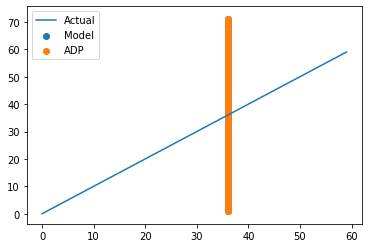

RB


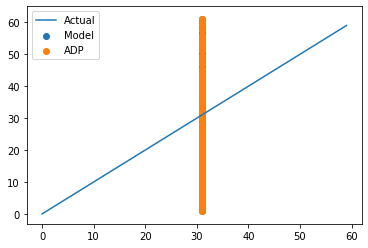

QB


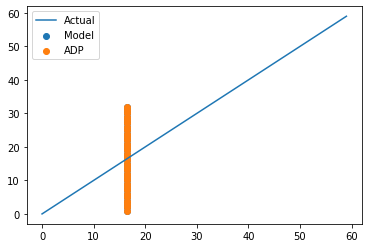

TE


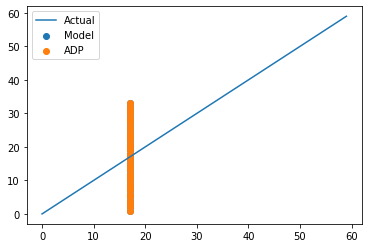

   Year Pos ADP_As_Predictor Points_Last_As_Predictor Model_As_Predictor
0  2018  WR          29819.5                    29820              29820
1  2018  RB          18908.5                    18909              18910
2  2018  QB             2728                     2728               2728
3  2018  TE             2992                   2991.5               2992
TE
Variable: Overall              Importance: 0.18
Variable: Dash                 Importance: 0.05
Variable: agesq                Importance: 0.05
Variable: Tgt                  Importance: 0.04
Variable: ReYds                Importance: 0.04
Variable: Tgt_per_game         Importance: 0.04
Variable: NOR                  Importance: 0.04
Variable: OvRank               Importance: 0.03
Variable: Std.Dev              Importance: 0.03
Variable: height               Importance: 0.03
Variable: Wt                   Importance: 0.03
Variable: Age                  Importance: 0.02
Variable: GS                   Importance: 0.02
Variable

Variable: Overall              Importance: 0.35
Variable: ppg_this_year        Importance: 0.05
Variable: Rec_per_tgt          Importance: 0.03
Variable: Tgt_per_game         Importance: 0.03
Variable: Std.Dev              Importance: 0.03
Variable: Pick                 Importance: 0.03
Variable: ReYds                Importance: 0.02
Variable: PPR                  Importance: 0.02
Variable: FDPt                 Importance: 0.02
Variable: ReTD_per_rec         Importance: 0.02
Variable: start_frac           Importance: 0.02
Variable: RuAtt_per_game       Importance: 0.02
Variable: Fant_Share           Importance: 0.02
Variable: Vertical             Importance: 0.02
Variable: Age                  Importance: 0.01
Variable: GS                   Importance: 0.01
Variable: RuAtt                Importance: 0.01
Variable: RuYds                Importance: 0.01
Variable: RuY/A                Importance: 0.01
Variable: RuTD                 Importance: 0.01
Variable: Tgt                  Importanc

WR


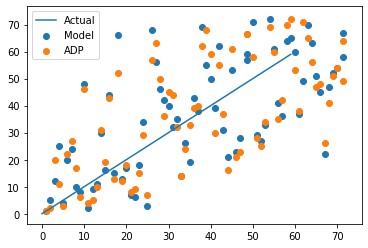

RB


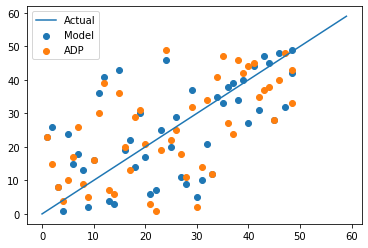

QB


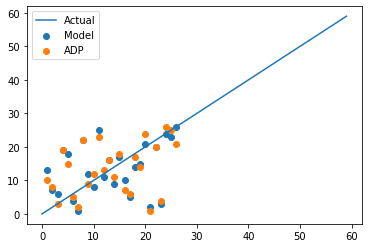

TE


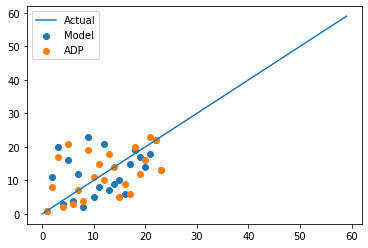

   Year Pos ADP_As_Predictor Points_Last_As_Predictor Model_As_Predictor
0  2014  WR          22000.5                    30129              22178
1  2014  RB           7745.5                    12812             8586.5
2  2014  QB             1878                   2457.5               2038
3  2014  TE             1106                   1237.5               1208
TE
Variable: ReYds                Importance: 0.2
Variable: Overall              Importance: 0.09
Variable: Tgt_per_game         Importance: 0.05
Variable: Tgt                  Importance: 0.04
Variable: Rec                  Importance: 0.03
Variable: Rec_per_tgt          Importance: 0.03
Variable: ReTD_per_rec         Importance: 0.03
Variable: Std.Dev              Importance: 0.03
Variable: Pick                 Importance: 0.03
Variable: GS                   Importance: 0.02
Variable: ReYds/R              Importance: 0.02
Variable: FantPt               Importance: 0.02
Variable: PosRank              Importance: 0.02
Variable:

Variable: Overall              Importance: 0.31
Variable: ppg_this_year        Importance: 0.06
Variable: Std.Dev              Importance: 0.05
Variable: Rec                  Importance: 0.02
Variable: ReYds                Importance: 0.02
Variable: Rec_per_tgt          Importance: 0.02
Variable: start_frac           Importance: 0.02
Variable: Tgt_per_game         Importance: 0.02
Variable: RuAtt_per_game       Importance: 0.02
Variable: Fant_Share           Importance: 0.02
Variable: Vertical             Importance: 0.02
Variable: Age                  Importance: 0.01
Variable: G                    Importance: 0.01
Variable: GS                   Importance: 0.01
Variable: RuAtt                Importance: 0.01
Variable: RuYds                Importance: 0.01
Variable: RuY/A                Importance: 0.01
Variable: Tgt                  Importance: 0.01
Variable: ReYds/R              Importance: 0.01
Variable: FL                   Importance: 0.01
Variable: FantPt               Importanc

WR


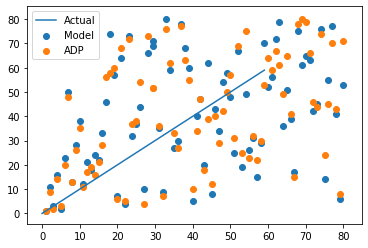

RB


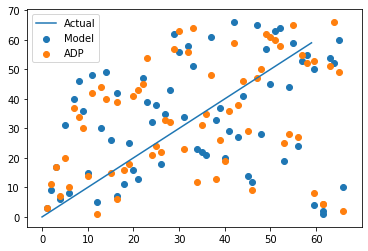

QB


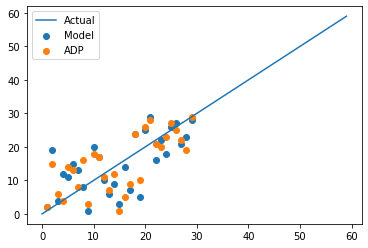

TE


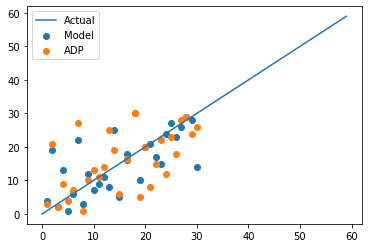

   Year Pos ADP_As_Predictor Points_Last_As_Predictor Model_As_Predictor
0  2015  WR            47728                  46761.5            54577.5
1  2015  RB            32241                  41639.5            34220.5
2  2015  QB             1256                     1986               1492
3  2015  TE             1920                   1687.5             1503.5
TE
Variable: ReYds                Importance: 0.09
Variable: Overall              Importance: 0.09
Variable: Rec                  Importance: 0.08
Variable: PosRank              Importance: 0.06
Variable: Tgt_per_game         Importance: 0.05
Variable: Std.Dev              Importance: 0.05
Variable: Pick                 Importance: 0.05
Variable: FantPt               Importance: 0.04
Variable: Rec_per_tgt          Importance: 0.04
Variable: ReTD_per_rec         Importance: 0.04
Variable: Age                  Importance: 0.02
Variable: GS                   Importance: 0.02
Variable: Tgt                  Importance: 0.02
Variable

Variable: Overall              Importance: 0.24
Variable: Std.Dev              Importance: 0.07
Variable: ppg_this_year        Importance: 0.05
Variable: Rec_per_tgt          Importance: 0.03
Variable: RuAtt_per_game       Importance: 0.03
Variable: Vertical             Importance: 0.03
Variable: Age                  Importance: 0.02
Variable: Rec                  Importance: 0.02
Variable: ReYds                Importance: 0.02
Variable: ReYds/R              Importance: 0.02
Variable: G_prev_year          Importance: 0.02
Variable: season_frac_2        Importance: 0.02
Variable: ReYds_per_R          Importance: 0.02
Variable: RuTD_per_Att         Importance: 0.02
Variable: Tgt_per_game         Importance: 0.02
Variable: Pick                 Importance: 0.02
Variable: Wt                   Importance: 0.02
Variable: Three_Cone           Importance: 0.02
Variable: Win_PCT              Importance: 0.02
Variable: agesq                Importance: 0.02
Variable: G                    Importanc

WR


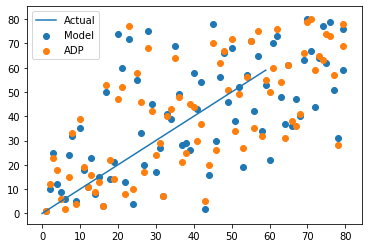

RB


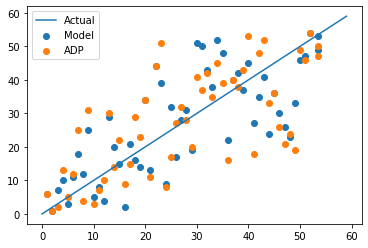

QB


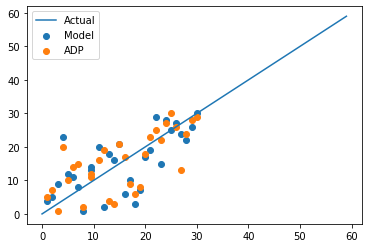

TE


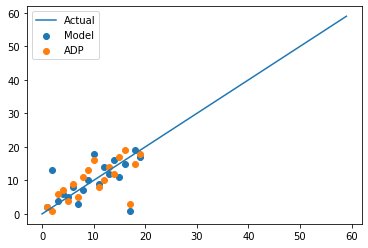

   Year Pos ADP_As_Predictor Points_Last_As_Predictor Model_As_Predictor
0  2016  WR          28950.5                  38230.5            33638.5
1  2016  RB           8032.5                     9468             6651.5
2  2016  QB           1406.5                   1635.5             1532.5
3  2016  TE              332                      584                504
TE
Variable: ReYds                Importance: 0.21
Variable: Overall              Importance: 0.1
Variable: Rec                  Importance: 0.09
Variable: Rec_per_tgt          Importance: 0.07
Variable: ReTD_per_rec         Importance: 0.04
Variable: Tgt_per_game         Importance: 0.03
Variable: Pick                 Importance: 0.03
Variable: Shuttle              Importance: 0.03
Variable: Tgt                  Importance: 0.02
Variable: ReYds/R              Importance: 0.02
Variable: PosRank              Importance: 0.02
Variable: ppg_this_year        Importance: 0.02
Variable: season_frac_2        Importance: 0.02
Variable:

Variable: Overall              Importance: 0.32
Variable: ppg_this_year        Importance: 0.04
Variable: Tgt_per_game         Importance: 0.03
Variable: Std.Dev              Importance: 0.03
Variable: Vertical             Importance: 0.03
Variable: RuAtt                Importance: 0.02
Variable: Rec                  Importance: 0.02
Variable: season_frac_2        Importance: 0.02
Variable: Rec_per_tgt          Importance: 0.02
Variable: RuAtt_per_game       Importance: 0.02
Variable: Bench                Importance: 0.02
Variable: Broad_Jump           Importance: 0.02
Variable: Three_Cone           Importance: 0.02
Variable: Win_PCT              Importance: 0.02
Variable: Age                  Importance: 0.01
Variable: G                    Importance: 0.01
Variable: GS                   Importance: 0.01
Variable: RuYds                Importance: 0.01
Variable: RuY/A                Importance: 0.01
Variable: RuTD                 Importance: 0.01
Variable: Tgt                  Importanc

WR


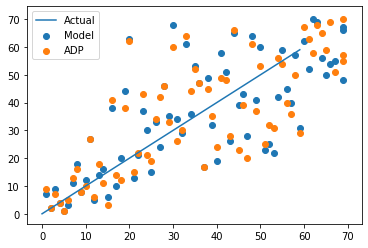

RB


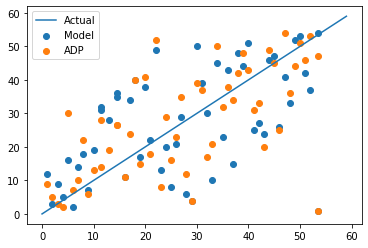

QB


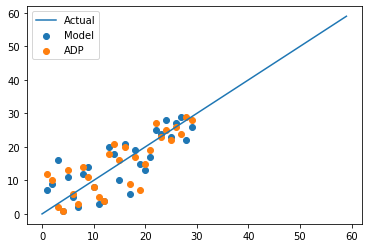

TE


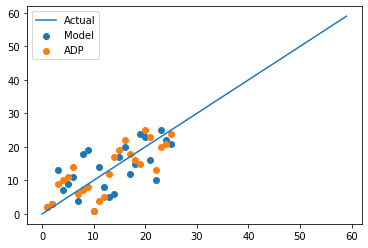

   Year Pos ADP_As_Predictor Points_Last_As_Predictor Model_As_Predictor
0  2017  WR            14050                    22832              15112
1  2017  RB             9827                    18280            12469.5
2  2017  QB              794                   2413.5                896
3  2017  TE              568                      822                876
TE
Variable: Overall              Importance: 0.27
Variable: ReYds                Importance: 0.13
Variable: Rec                  Importance: 0.07
Variable: Rec_per_tgt          Importance: 0.06
Variable: ReTD_per_rec         Importance: 0.03
Variable: Std.Dev              Importance: 0.03
Variable: Tgt                  Importance: 0.02
Variable: PosRank              Importance: 0.02
Variable: G_prev_year          Importance: 0.02
Variable: ppg_this_year        Importance: 0.02
Variable: season_frac_2        Importance: 0.02
Variable: Tgt_per_game         Importance: 0.02
Variable: Fant_Share           Importance: 0.02
Variable

Variable: Overall              Importance: 0.32
Variable: Std.Dev              Importance: 0.06
Variable: ppg_this_year        Importance: 0.04
Variable: Tgt_per_game         Importance: 0.03
Variable: RuAtt_per_game       Importance: 0.03
Variable: Win_PCT              Importance: 0.03
Variable: Age                  Importance: 0.02
Variable: RuAtt                Importance: 0.02
Variable: Rec                  Importance: 0.02
Variable: season_frac_2        Importance: 0.02
Variable: season_frac_3        Importance: 0.02
Variable: Rec_per_tgt          Importance: 0.02
Variable: Pick                 Importance: 0.02
Variable: Vertical             Importance: 0.02
Variable: Three_Cone           Importance: 0.02
Variable: GS                   Importance: 0.01
Variable: RuYds                Importance: 0.01
Variable: RuY/A                Importance: 0.01
Variable: RuTD                 Importance: 0.01
Variable: Tgt                  Importance: 0.01
Variable: ReYds                Importanc

WR


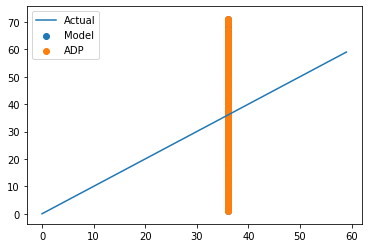

RB


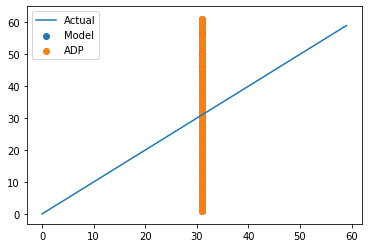

QB


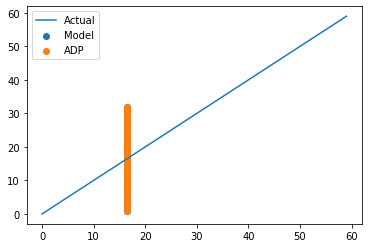

TE


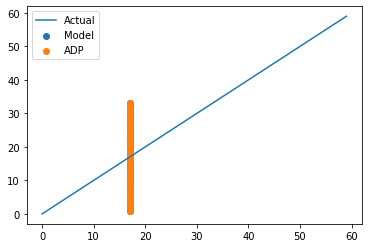

   Year Pos ADP_As_Predictor Points_Last_As_Predictor Model_As_Predictor
0  2018  WR          29819.5                    29820              29820
1  2018  RB          18908.5                    18909              18910
2  2018  QB             2728                     2728               2728
3  2018  TE             2992                   2991.5               2992
TE
Variable: Overall              Importance: 0.12
Variable: ReYds                Importance: 0.11
Variable: Tgt                  Importance: 0.08
Variable: Tgt_per_game         Importance: 0.06
Variable: GS                   Importance: 0.03
Variable: ppg_this_year        Importance: 0.03
Variable: Std.Dev              Importance: 0.03
Variable: height               Importance: 0.03
Variable: Wt                   Importance: 0.03
Variable: Age                  Importance: 0.02
Variable: Rec                  Importance: 0.02
Variable: PosRank              Importance: 0.02
Variable: G_prev_year          Importance: 0.02
Variable

Variable: Overall              Importance: 0.28
Variable: ppg_this_year        Importance: 0.11
Variable: Std.Dev              Importance: 0.03
Variable: Vertical             Importance: 0.03
Variable: Tgt                  Importance: 0.02
Variable: Rec                  Importance: 0.02
Variable: ReYds                Importance: 0.02
Variable: DKPt                 Importance: 0.02
Variable: FDPt                 Importance: 0.02
Variable: Rec_per_tgt          Importance: 0.02
Variable: Tgt_per_game         Importance: 0.02
Variable: RuAtt_per_game       Importance: 0.02
Variable: Fant_Share           Importance: 0.02
Variable: Pick                 Importance: 0.02
Variable: height               Importance: 0.02
Variable: Win_PCT              Importance: 0.02
Variable: Age                  Importance: 0.01
Variable: GS                   Importance: 0.01
Variable: RuAtt                Importance: 0.01
Variable: RuYds                Importance: 0.01
Variable: RuY/A                Importanc

WR


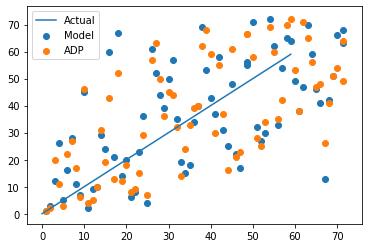

RB


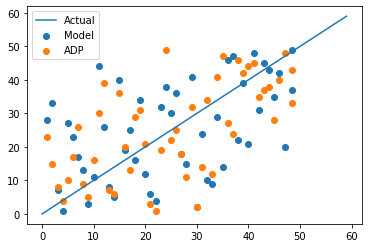

QB


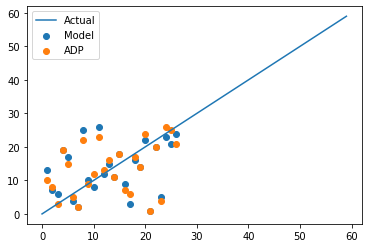

TE


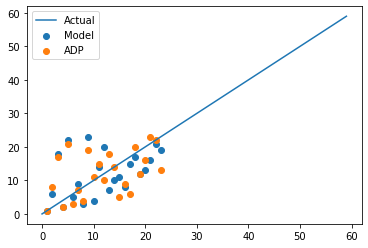

   Year Pos ADP_As_Predictor Points_Last_As_Predictor Model_As_Predictor
0  2014  WR          22000.5                    30129              24703
1  2014  RB           7745.5                    12812            10705.5
2  2014  QB             1878                   2457.5               2144
3  2014  TE             1106                   1237.5               1146
TE
Variable: Tgt_per_game         Importance: 0.08
Variable: Overall              Importance: 0.07
Variable: Tgt                  Importance: 0.06
Variable: Rec                  Importance: 0.05
Variable: ReYds                Importance: 0.05
Variable: FantPt               Importance: 0.05
Variable: Std.Dev              Importance: 0.05
Variable: ReTD_per_rec         Importance: 0.04
Variable: PosRank              Importance: 0.03
Variable: season_frac_3        Importance: 0.03
Variable: Rec_per_tgt          Importance: 0.03
Variable: Pick                 Importance: 0.03
Variable: Wt                   Importance: 0.03
Variable

Variable: Overall              Importance: 0.19
Variable: ppg_this_year        Importance: 0.14
Variable: Std.Dev              Importance: 0.11
Variable: ReYds                Importance: 0.03
Variable: Rec_per_tgt          Importance: 0.03
Variable: Tgt_per_game         Importance: 0.03
Variable: ReYds/R              Importance: 0.02
Variable: RuTD_per_Att         Importance: 0.02
Variable: start_frac           Importance: 0.02
Variable: RuAtt_per_game       Importance: 0.02
Variable: height               Importance: 0.02
Variable: Vertical             Importance: 0.02
Variable: Age                  Importance: 0.01
Variable: GS                   Importance: 0.01
Variable: RuAtt                Importance: 0.01
Variable: RuYds                Importance: 0.01
Variable: RuY/A                Importance: 0.01
Variable: Tgt                  Importance: 0.01
Variable: Rec                  Importance: 0.01
Variable: FL                   Importance: 0.01
Variable: TD.3                 Importanc

WR


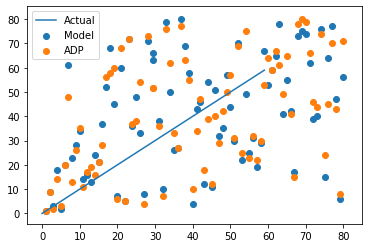

RB


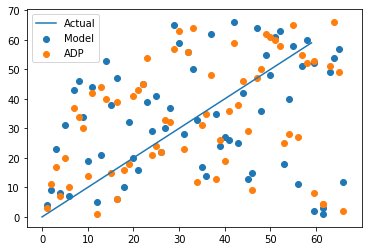

QB


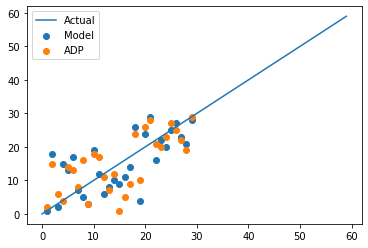

TE


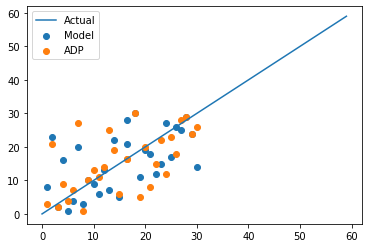

   Year Pos ADP_As_Predictor Points_Last_As_Predictor Model_As_Predictor
0  2015  WR            47728                  46761.5            52154.5
1  2015  RB            32241                  41639.5            36191.5
2  2015  QB             1256                     1986               1326
3  2015  TE             1920                   1687.5             1970.5
TE
Variable: Rec                  Importance: 0.15
Variable: ReYds                Importance: 0.15
Variable: Rec_per_tgt          Importance: 0.06
Variable: Tgt_per_game         Importance: 0.06
Variable: Overall              Importance: 0.06
Variable: Pick                 Importance: 0.06
Variable: ReTD_per_rec         Importance: 0.03
Variable: Shuttle              Importance: 0.03
Variable: Age                  Importance: 0.02
Variable: Tgt                  Importance: 0.02
Variable: ReYds/R              Importance: 0.02
Variable: PosRank              Importance: 0.02
Variable: G_prev_year          Importance: 0.02
Variable

Variable: Overall              Importance: 0.29
Variable: ppg_this_year        Importance: 0.05
Variable: Std.Dev              Importance: 0.04
Variable: Vertical             Importance: 0.04
Variable: RuAtt_per_game       Importance: 0.03
Variable: G_prev_year          Importance: 0.02
Variable: season_frac_2        Importance: 0.02
Variable: ReYds_per_R          Importance: 0.02
Variable: Rec_per_tgt          Importance: 0.02
Variable: ReTD_per_rec         Importance: 0.02
Variable: Tgt_per_game         Importance: 0.02
Variable: Pick                 Importance: 0.02
Variable: Wt                   Importance: 0.02
Variable: Broad_Jump           Importance: 0.02
Variable: Three_Cone           Importance: 0.02
Variable: Shuttle              Importance: 0.02
Variable: Win_PCT              Importance: 0.02
Variable: Age                  Importance: 0.01
Variable: G                    Importance: 0.01
Variable: GS                   Importance: 0.01
Variable: RuAtt                Importanc

WR


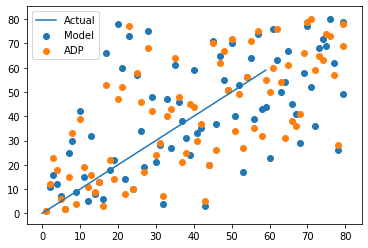

RB


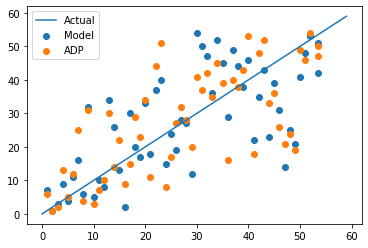

QB


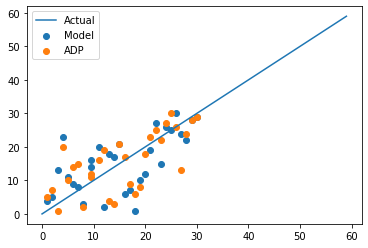

TE


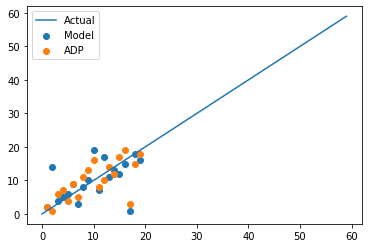

   Year Pos ADP_As_Predictor Points_Last_As_Predictor Model_As_Predictor
0  2016  WR          28950.5                  38230.5            35667.5
1  2016  RB           8032.5                     9468             8424.5
2  2016  QB           1406.5                   1635.5             1657.5
3  2016  TE              332                      584                576
TE
Variable: ReYds                Importance: 0.15
Variable: Overall              Importance: 0.14
Variable: Rec_per_tgt          Importance: 0.1
Variable: Rec                  Importance: 0.09
Variable: ppg_this_year        Importance: 0.05
Variable: ReTD_per_rec         Importance: 0.03
Variable: Std.Dev              Importance: 0.03
Variable: Pick                 Importance: 0.03
Variable: Tgt                  Importance: 0.02
Variable: ReYds/R              Importance: 0.02
Variable: PosRank              Importance: 0.02
Variable: G_prev_year          Importance: 0.02
Variable: ReYds_per_R          Importance: 0.02
Variable:

Variable: Overall              Importance: 0.32
Variable: RuAtt                Importance: 0.03
Variable: ppg_this_year        Importance: 0.03
Variable: Tgt_per_game         Importance: 0.03
Variable: Vertical             Importance: 0.03
Variable: Win_PCT              Importance: 0.03
Variable: RuYds                Importance: 0.02
Variable: Rec                  Importance: 0.02
Variable: ReYds/R              Importance: 0.02
Variable: season_frac_2        Importance: 0.02
Variable: ReYds_per_R          Importance: 0.02
Variable: Rec_per_tgt          Importance: 0.02
Variable: RuAtt_per_game       Importance: 0.02
Variable: Std.Dev              Importance: 0.02
Variable: Pick                 Importance: 0.02
Variable: Wt                   Importance: 0.02
Variable: Bench                Importance: 0.02
Variable: Three_Cone           Importance: 0.02
Variable: Shuttle              Importance: 0.02
Variable: Age                  Importance: 0.01
Variable: G                    Importanc

WR


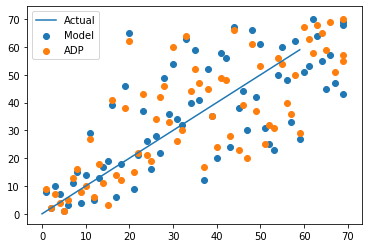

RB


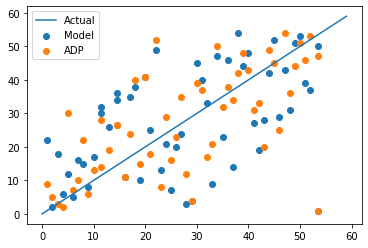

QB


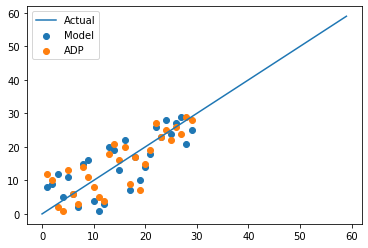

TE


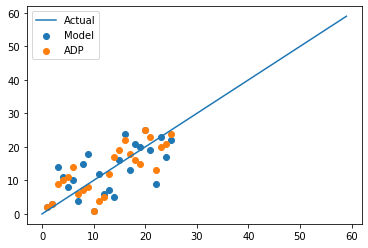

   Year Pos ADP_As_Predictor Points_Last_As_Predictor Model_As_Predictor
0  2017  WR            14050                    22832              16154
1  2017  RB             9827                    18280            13335.5
2  2017  QB              794                   2413.5               1000
3  2017  TE              568                      822                918
TE
Variable: Overall              Importance: 0.27
Variable: ReYds                Importance: 0.14
Variable: Rec_per_tgt          Importance: 0.05
Variable: Rec                  Importance: 0.04
Variable: Fant_Share           Importance: 0.04
Variable: Std.Dev              Importance: 0.03
Variable: FantPt               Importance: 0.02
Variable: PosRank              Importance: 0.02
Variable: G_prev_year          Importance: 0.02
Variable: ppg_this_year        Importance: 0.02
Variable: season_frac_2        Importance: 0.02
Variable: ReTD_per_rec         Importance: 0.02
Variable: Shuttle              Importance: 0.02
Variable

Variable: Overall              Importance: 0.33
Variable: Std.Dev              Importance: 0.05
Variable: ppg_this_year        Importance: 0.04
Variable: RuAtt                Importance: 0.03
Variable: Tgt_per_game         Importance: 0.03
Variable: Age                  Importance: 0.02
Variable: Tgt                  Importance: 0.02
Variable: Rec                  Importance: 0.02
Variable: ReYds                Importance: 0.02
Variable: season_frac_2        Importance: 0.02
Variable: season_frac_3        Importance: 0.02
Variable: RuTD_per_Att         Importance: 0.02
Variable: Rec_per_tgt          Importance: 0.02
Variable: RuAtt_per_game       Importance: 0.02
Variable: Fant_Share           Importance: 0.02
Variable: Win_PCT              Importance: 0.02
Variable: RuYds                Importance: 0.01
Variable: RuY/A                Importance: 0.01
Variable: RuTD                 Importance: 0.01
Variable: ReYds/R              Importance: 0.01
Variable: ReTD                 Importanc

WR


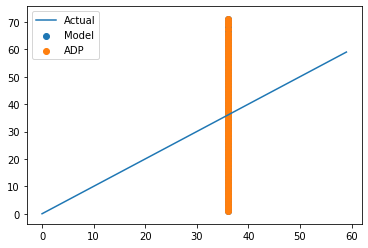

RB


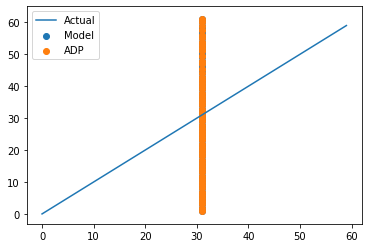

QB


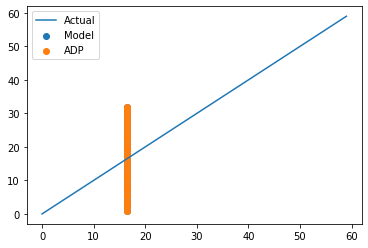

TE


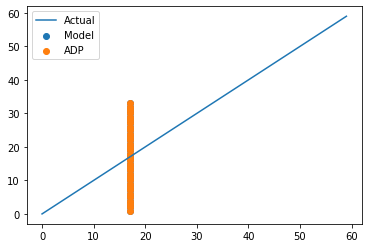

   Year Pos ADP_As_Predictor Points_Last_As_Predictor Model_As_Predictor
0  2018  WR          29819.5                    29820              29820
1  2018  RB          18908.5                    18909              18910
2  2018  QB             2728                     2728               2728
3  2018  TE             2992                   2991.5               2992


,Names,prediction,Overall,PPR,Win_PCT
32,Christian McCaffrey,305.641333,1.61,385.5,43.8
12,Alvin Kamara,284.408767,5.71,354.2,81.2
57,Saquon Barkley,275.043200,3.42,385.8,31.2
14,Ezekiel Elliott,261.387900,4.82,329.1,62.5
30,Todd Gurley,239.104467,28.47,372.1,81.2
24,James Conner,225.799533,17.72,280.0,60.0
22,Melvin Gordon,205.057333,47.24,275.5,75.0
4,Dalvin Cook,193.817867,5.22,152.0,53.3
1,Joe Mixon,191.328700,57.47,243.4,37.5
41,Leonard Fournette,175.972567,14.61,120.4,31.2


In [23]:
all_cross_val = {}
for sz in [10, 9, 8, 7, 6, 5, 4]:
    cross_val = {}
    #################### take out final year where pts next year are all NULL ###################
    ## chose the year one before, ex: want to predict for 2019 season choose 2018, last year of data
    for predict_year in [2014, 2015, 2016, 2017, 2018]:
        #### replace na's with mean of column ###########################
        model_dict = {}
        predict_dict = {}
        predict_names = {}
        predict_pts_next = {}
        for pos in pos_dict:
            print(pos)
            test = copy.deepcopy(pos_dict[pos])
            target = test.drop(['Rk', 'FantPos', 'College', 'Old_Team',
                        '2PP', 'delta_ppg', 'ppg_next_year', 'g_next_year'], axis=1)
            # team dummy variables
            dum = pd.get_dummies(target.Tm)
            target = target[[x for x in target.columns if ('Tm' not in x and 'Team' not in x)]]
            target = pd.concat([target, dum], axis=1)
            # need separate predictions
            predict_names[pos] = target.loc[target.Year == predict_year]\
                .reset_index(drop = True)['Name']
            predict_pts_next[pos] = target.loc[target.Year == predict_year]\
                .reset_index(drop = True)['pts_next_year']
            predict_dict[pos] = target.loc[target.Year == predict_year]\
                .reset_index(drop = True)\
                .drop(['Year', 'pts_next_year', 'Name'], axis=1)
            target = target.loc[target.Year < predict_year]\
                .reset_index(drop = True)

            # only use 10 years of data before prediction year
            target = target.loc[target.Year > predict_year - sz].drop(['Year', 'Name'], axis=1)

            # separate labels, targets, features
            labels = target['pts_next_year']
            target = target.drop(['pts_next_year'], axis = 1)
            feature_list = list(target.columns)
            features = np.array(target)
            labels = np.array(labels)

            # run modle 
            rf = RandomForestRegressor(n_estimators = 3000, random_state = 42)
            rf.fit(features, labels)
            model_dict[pos] = rf

            # Get numerical feature importances
            importances = list(rf.feature_importances_)
            feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
            feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
            [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]


        ### handle outputs
        final_dict = copy.deepcopy(predict_dict)
        output_dict = {}
        for pos in predict_dict:
            names = predict_names[pos]
            actual_pts = predict_pts_next[pos]
            #print(frame)
            #print([x for x in list(final_dict[pos].columns) if x not in feature_list])
            model = model_dict[pos]
            final_dict[pos]['prediction'] = model.predict(predict_dict[pos])
            final_dict[pos]['Names'] = names
            final_dict[pos]['pts_next_year'] = actual_pts

        ##### create R-Sq frame for results comparison #################################
        results_frame = pd.DataFrame()
        results_frame['Year'] = '_'
        results_frame['Pos'] = '_'
        results_frame['ADP_As_Predictor'] = '_'
        results_frame['Points_Last_As_Predictor'] = '_'
        results_frame['Model_As_Predictor'] = '_'

        for pos in ['WR', 'RB', 'QB', 'TE']:
            results_frame.loc[len(results_frame), 'Year'] = predict_year
            results_frame.loc[len(results_frame) - 1, 'Pos'] = pos
            testtest = final_dict[pos].sort_values(
                ['prediction'], ascending = False
            )[[
                'Names'
                , 'PPR'
                , 'Overall'
                , 'prediction'
                , 'pts_next_year']].reset_index(drop = True)
            testtest['Last_Year_Pos_Rank'] = testtest['PPR'].rank(ascending = False)
            testtest['ADP_Pos_Rank'] = testtest['Overall'].rank()
            testtest['Predicted_Pos_Rank'] = testtest['prediction'].rank(ascending = False)
            testtest['Actual_Next_Pos_Rank'] = testtest['pts_next_year'].rank(ascending = False)
            print(pos)
            plt.scatter(testtest['Actual_Next_Pos_Rank'], testtest['Predicted_Pos_Rank'], label = 'Model')
            plt.scatter(testtest['Actual_Next_Pos_Rank'], testtest['ADP_Pos_Rank'], label = 'ADP')
            #plt.scatter(testtest['Actual_Next_Pos_Rank'], testtest['Last_Year_Pos_Rank'], label = 'Points Last Year')
            plt.plot(range(60), range(60), label = 'Actual')
            plt.legend(loc='upper left')

            plt.show()

            val = sum((testtest['ADP_Pos_Rank'] - testtest['Actual_Next_Pos_Rank'])**2)
            results_frame.loc[len(results_frame) - 1, 'ADP_As_Predictor'] = val
            val = sum((testtest['Last_Year_Pos_Rank'] - testtest['Actual_Next_Pos_Rank'])**2)
            results_frame.loc[len(results_frame) - 1, 'Points_Last_As_Predictor'] = val
            val = sum((testtest['Predicted_Pos_Rank'] - testtest['Actual_Next_Pos_Rank'])**2)
            results_frame.loc[len(results_frame) - 1, 'Model_As_Predictor'] = val
            cross_val[predict_year] = results_frame
        print(results_frame)
    all_cross_val[sz] = cross_val
output_dict = copy.deepcopy(final_dict)
output_dict[pos][['Names', 'prediction', 'PPR']]

output_dict['TE'][['Names', 'prediction', 'Overall', 'PPR', 'Win_PCT']]\
.sort_values('prediction', ascending = False)\
.to_csv('test.csv', index = False)

output_dict['RB'].sort_values('prediction', ascending = False)[['Names', 'prediction', 'Overall', 'PPR', 'Win_PCT']]


In [39]:
shifted.groupby('Year').count()
#shifted.loc[shifted.Year == 2011].sort_values('Overall')
output_dict['TE'].sort_values('prediction', ascending = False)[['Names', 'prediction', 'Overall', 'PPR', 'Win_PCT']]



,Names,prediction,Overall,PPR,Win_PCT
26,Travis Kelce,214.153633,20.94,294.6,75.0
28,George Kittle,202.131267,33.83,258.7,25.0
7,Zach Ertz,193.888400,42.67,280.3,56.2
15,Vance McDonald,166.514700,131.17,133.0,60.0
8,Jared Cook,164.716433,117.89,193.6,81.2
2,Kyle Rudolph,162.467567,129.86,151.4,53.3
31,Evan Engram,161.956133,58.50,126.3,31.2
29,Eric Ebron,160.148900,87.64,222.2,62.5
13,Austin Hooper,159.503600,62.95,163.0,43.8
32,Mark Andrews,158.508867,79.61,107.2,62.5


In [35]:
for i in all_cross_val:
    print(i)
    print(all_cross_val[i][2018])
    
# 2014
# 8 is best for WR
# 10 is best for RB
# 10 is best for QB
# 6 is best for TE

# 2015
# 4 is best for WR
# 8 is best for RB
# 8 is best for QB
# 5 is best for TE

# 2016
# 8 is best for WR
# 5 is best for RB
# 7 is best for QB
# 10&9 are best for TE

# 2017
# 6 is best for WR
# 10 is best for RB
# 9 is best for QB
# 10 is best for TE


10
   Year Pos ADP_As_Predictor Points_Last_As_Predictor Model_As_Predictor
0  2018  WR          29819.5                    29820              29820
1  2018  RB          18908.5                    18909              18910
2  2018  QB             2728                     2728               2728
3  2018  TE             2992                   2991.5               2992
9
   Year Pos ADP_As_Predictor Points_Last_As_Predictor Model_As_Predictor
0  2018  WR          29819.5                    29820              29820
1  2018  RB          18908.5                    18909              18910
2  2018  QB             2728                     2728               2728
3  2018  TE             2992                   2991.5               2992
8
   Year Pos ADP_As_Predictor Points_Last_As_Predictor Model_As_Predictor
0  2018  WR          29819.5                    29820              29820
1  2018  RB          18908.5                    18909              18910
2  2018  QB             2728                